## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_bruxism.pk"
info_file = "data/data_info.csv"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change to --overwrite True if you want to force to recompute the results
%run ../compute_results.py --bruxism True --overwrite False --mema True


config loaded.
Performs Bruxism: <True>
Performs MEMA: <True>
Will overwrite existing results: <False>
parameters set
result files exist: Reports creation skipped.


# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('emg == 1 & included == 1 & session == "1"')
print(f"Valid files for bruxism {data_info.shape[0]}")
print(data_info[["filename", "condition"]])
results_updated = dict()
for filename in results.keys():
    if filename in data_info["filename"].values:
        results_updated[filename] = results[filename]
results = results_updated

Valid files for bruxism 19
              filename    condition
0   1BA07_nuit_hab.edf  habituation
2   1CC05_nuit_hab.edf  habituation
4   1DA15_nuit_hab.edf  habituation
6   1DL12_nuit_hab.edf  habituation
8   1GB18_nuit_son.edf  habituation
14  1MF19_nuit_hab.edf  habituation
16  1MN09_nuit_hab.edf  habituation
18  1PI07_nuit_hab.edf  habituation
20  1PT06_nuit_hab.edf  habituation
24  1SA14_nuit_hab.edf  habituation
26  1ZN04_nuit_hab.edf  habituation
28    1HB20_nuit_1.edf  habituation
36    1SL21_nuit_2.edf  habituation
40    1UC22_nuit_1.edf  habituation
42    2GA06_nuit_1.edf      control
43    2SJ03_nuit_1.edf      control
47    2GR01_nuit_1.edf      control
49    2LS05_nuit_1.edf      control
50    2CT04_nuit_1.edf      control


## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

In [5]:
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        number_episodes_per_hour=[]
        for report in results[filename]["reports"]:
            number_episodes_per_hour.append(report[value])
        plt.plot(THR_classif[:,1], number_episodes_per_hour, label=filename)
    plt.title('Bruxism scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

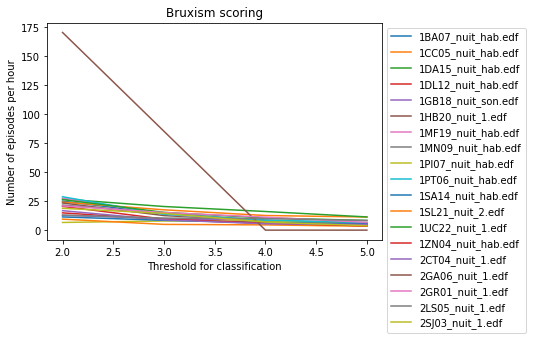

In [6]:
plt.close("all")
plt.figure()
value = "Number of episodes per hour"
plot_inter_subjects(results, value)

## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

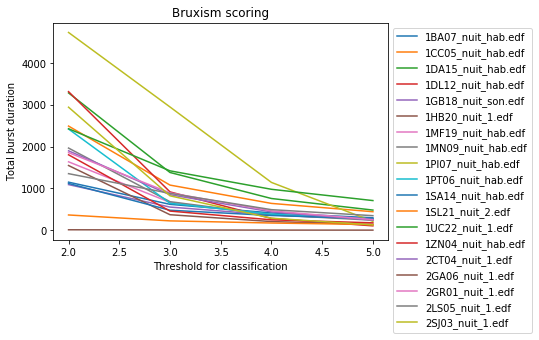

In [7]:
plt.figure()
value = "Total burst duration"
plot_inter_subjects(results, value)

## Logs of the preprocessing : 

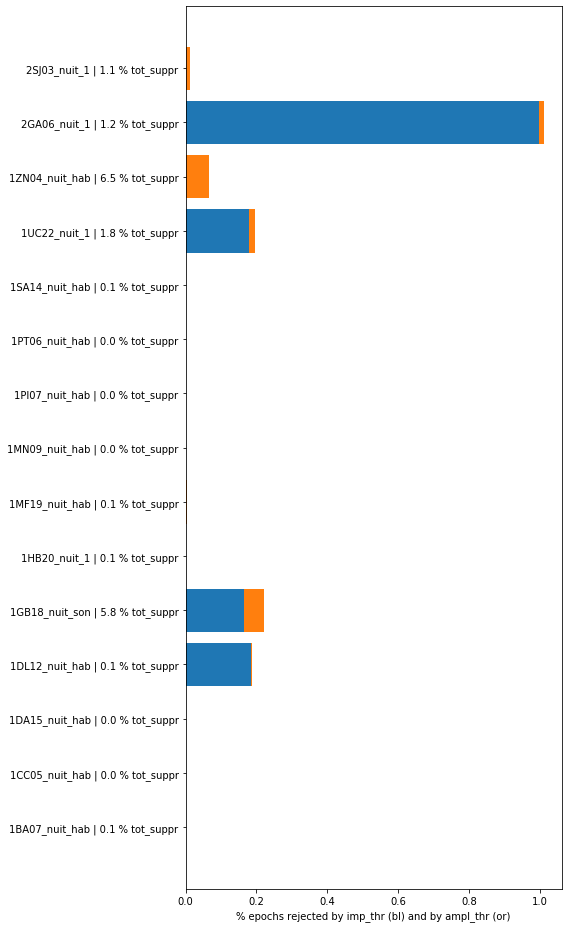

In [8]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results.keys():
    if results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results[elm]["log"]["IMP"]['suppressed_overall']/results[elm]["log"]["IMP"]['total_nb_epochs']))
        suppr_amp.append(results[elm]["log"]["bruxism"]['suppressed_overall']/results[elm]["log"]["bruxism"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Comparing episode frequency with variability tinnitus

In [9]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["mask_per"].apply(map_category)

reports = reports.merge(data_info, on="filename")

In [10]:
#Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus increase : 6, ['1BA07', '1GB18', '1MF19', '1SA14', '1ZN04', '1UC22']
Tinnitus stable : 7, ['1CC05', '1DA15', '1DL12', '1MN09', '1PI07', '1PT06', '1SL21']
Tinnitus decrease : 1, ['1HB20']
Tinnitus control : 5, ['2GA06', '2SJ03', '2GR01', '2LS05', '2CT04']


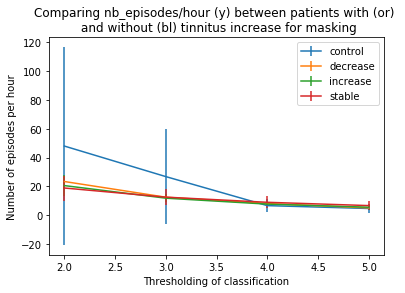

In [11]:
#Displaying
plt.figure()
value = "Number of episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

## Displaying correlation between quantitative measurements and Tinnitus

In [12]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-1] #(remove power ratio)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]

variables: ['Clean data duration', 'Total burst duration', 'Total number of burst', 'Number of bursts per hour', 'Total number of episodes', 'Number of bursts per episode', 'Number of episodes per hour', 'Number of tonic episodes per hour', 'Number of phasic episodes per hour', 'Number of mixed episodes per hour', 'Mean duration of tonic episode', 'Mean duration of phasic episode', 'Mean duration of mixed episode']


<ipython-input-13-8b2d9fa20982>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
<ipython-input-13-8b2d9fa20982>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
<ipython-input-13-8b2d9fa20982>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

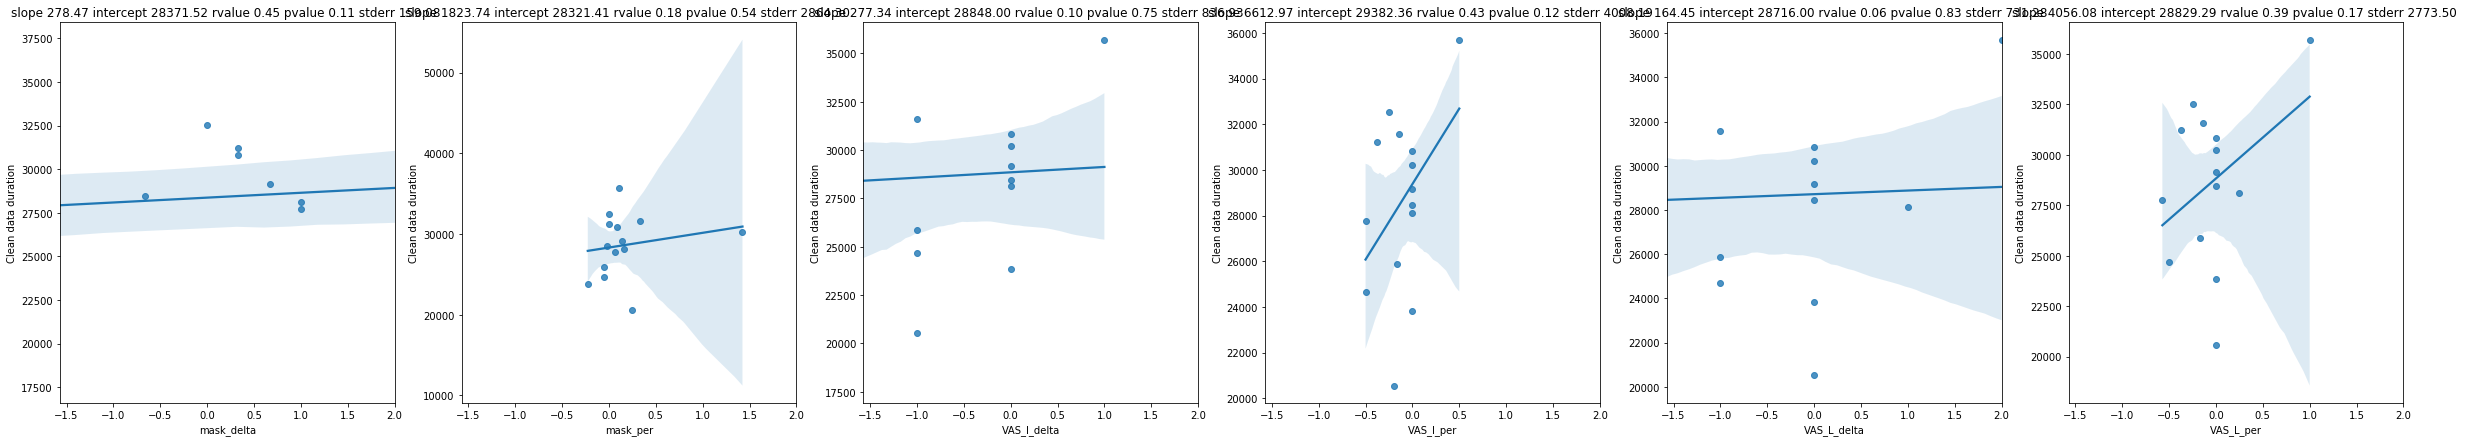

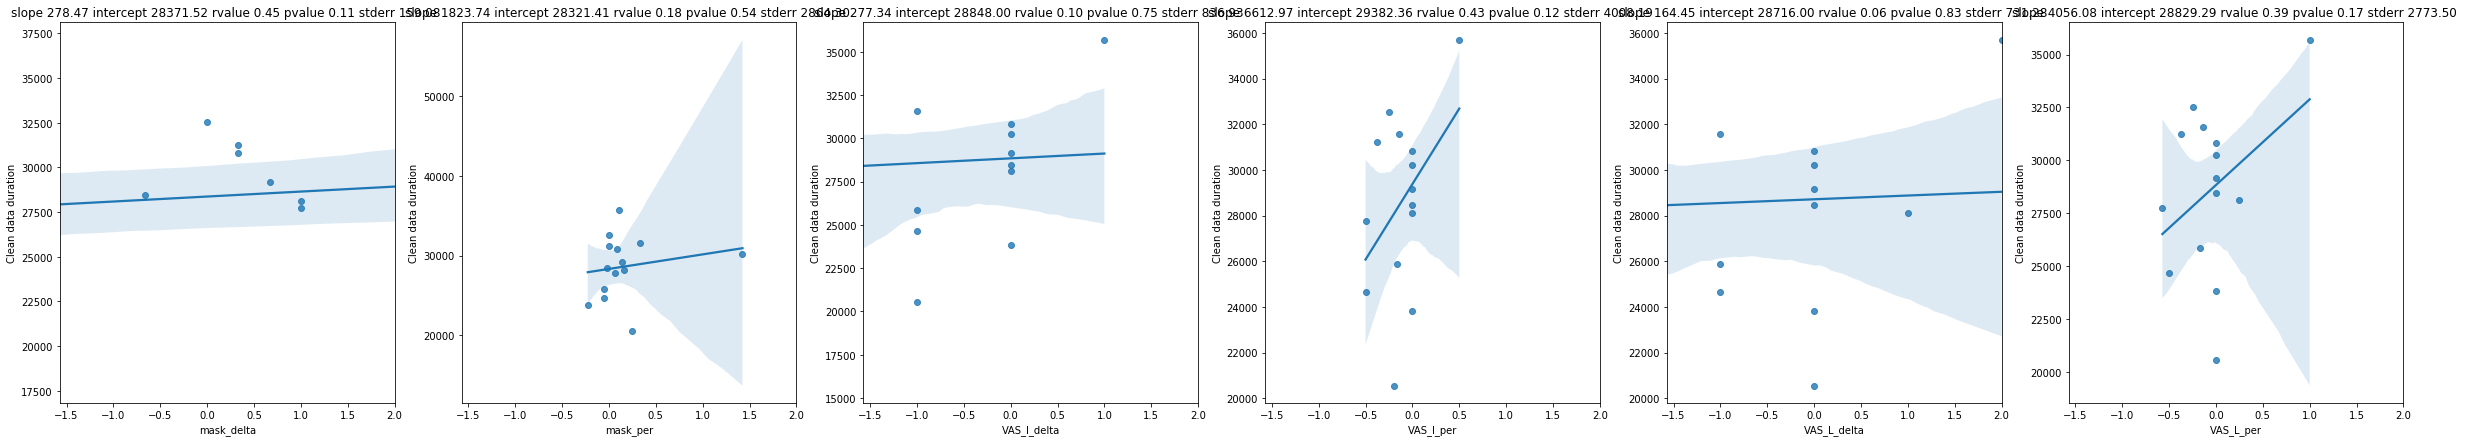

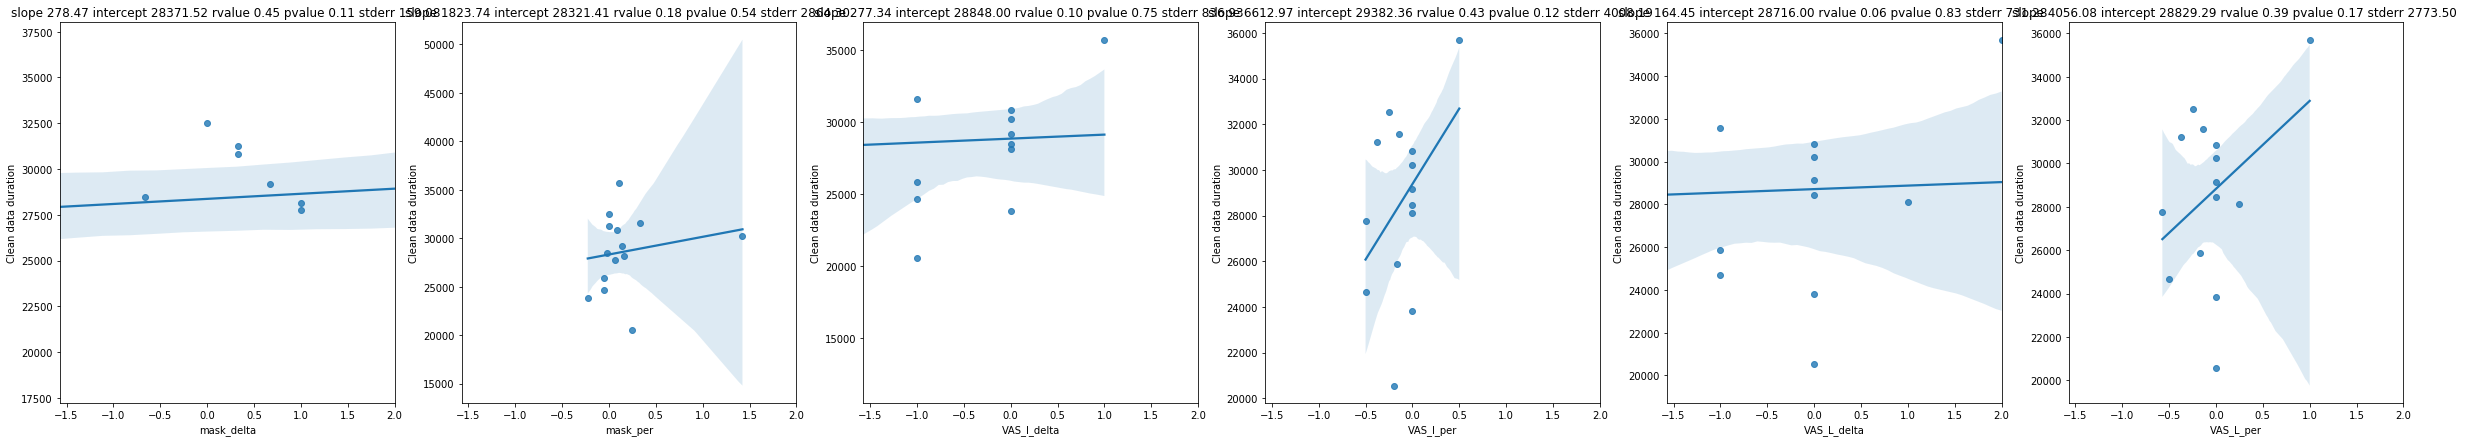

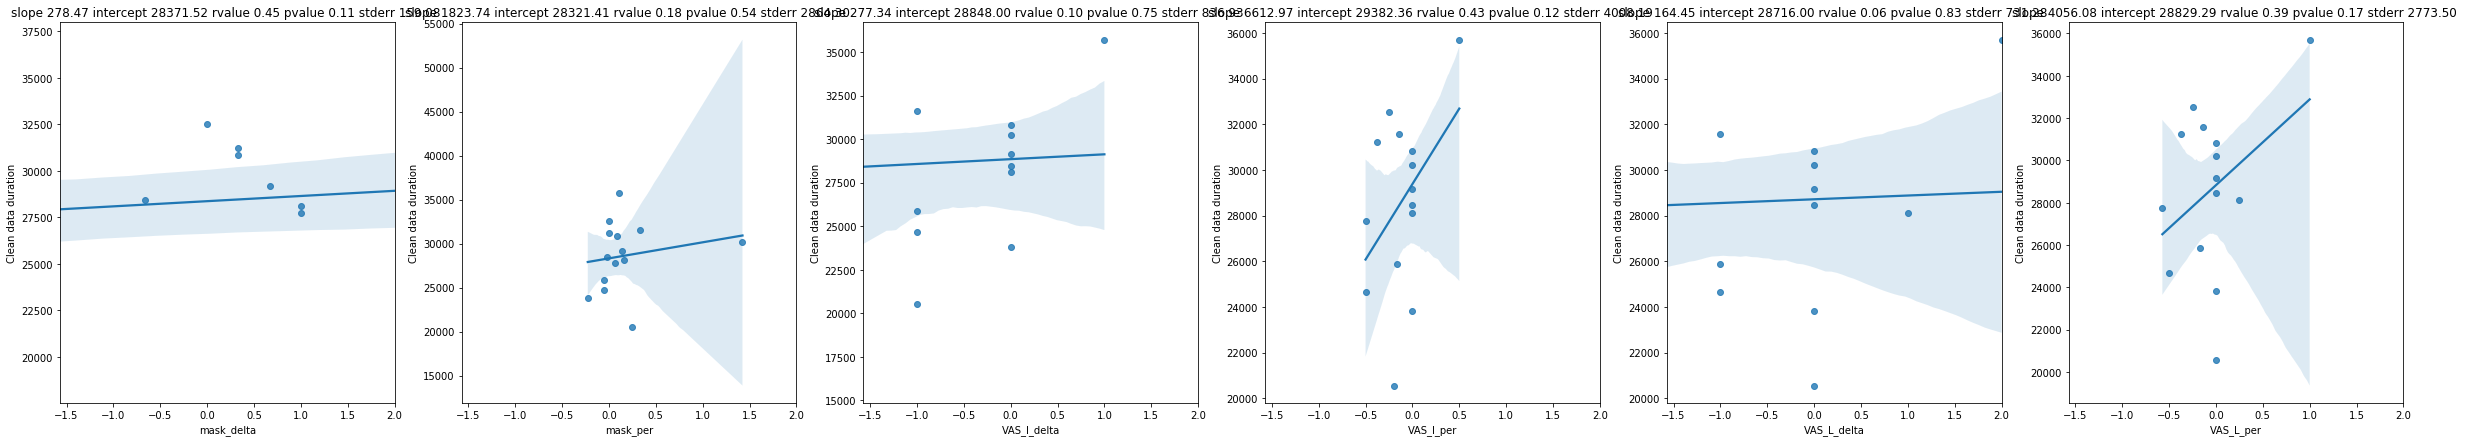

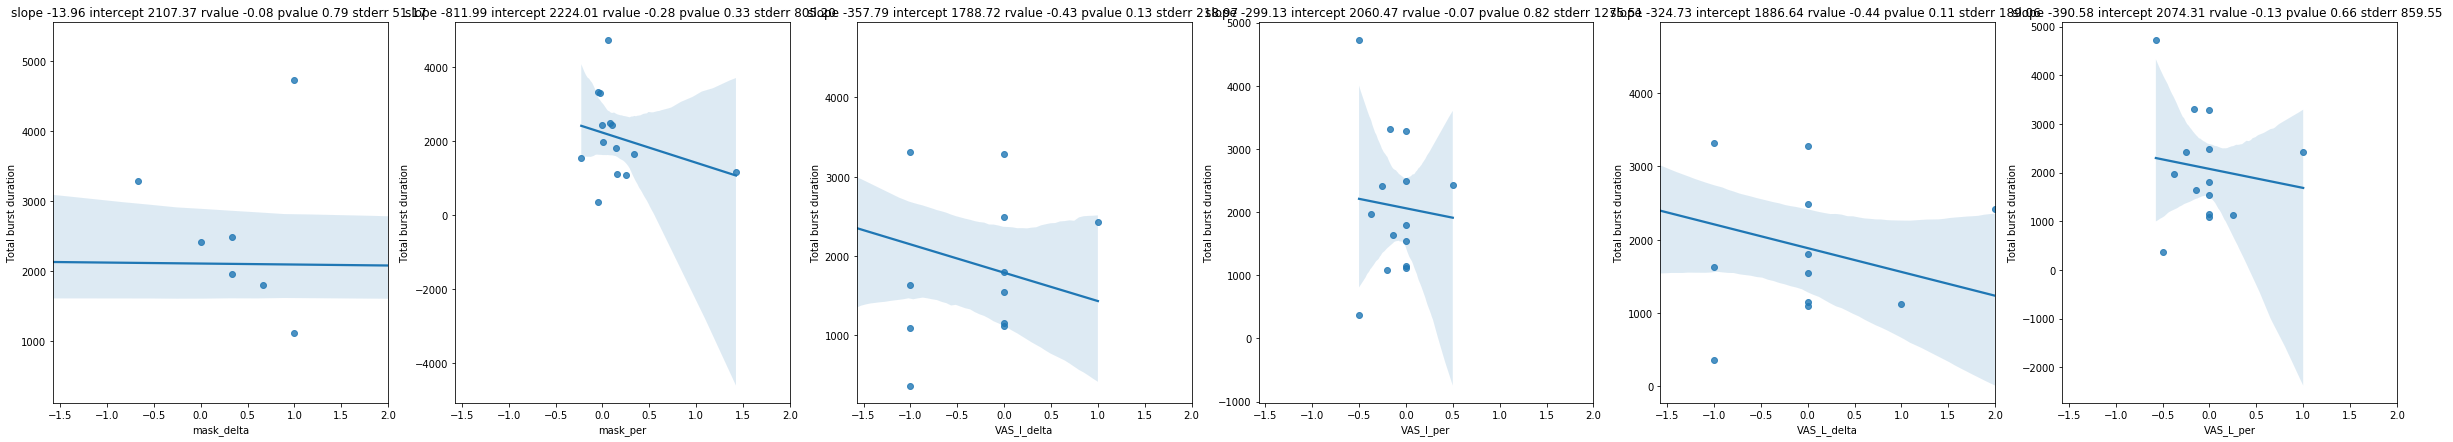

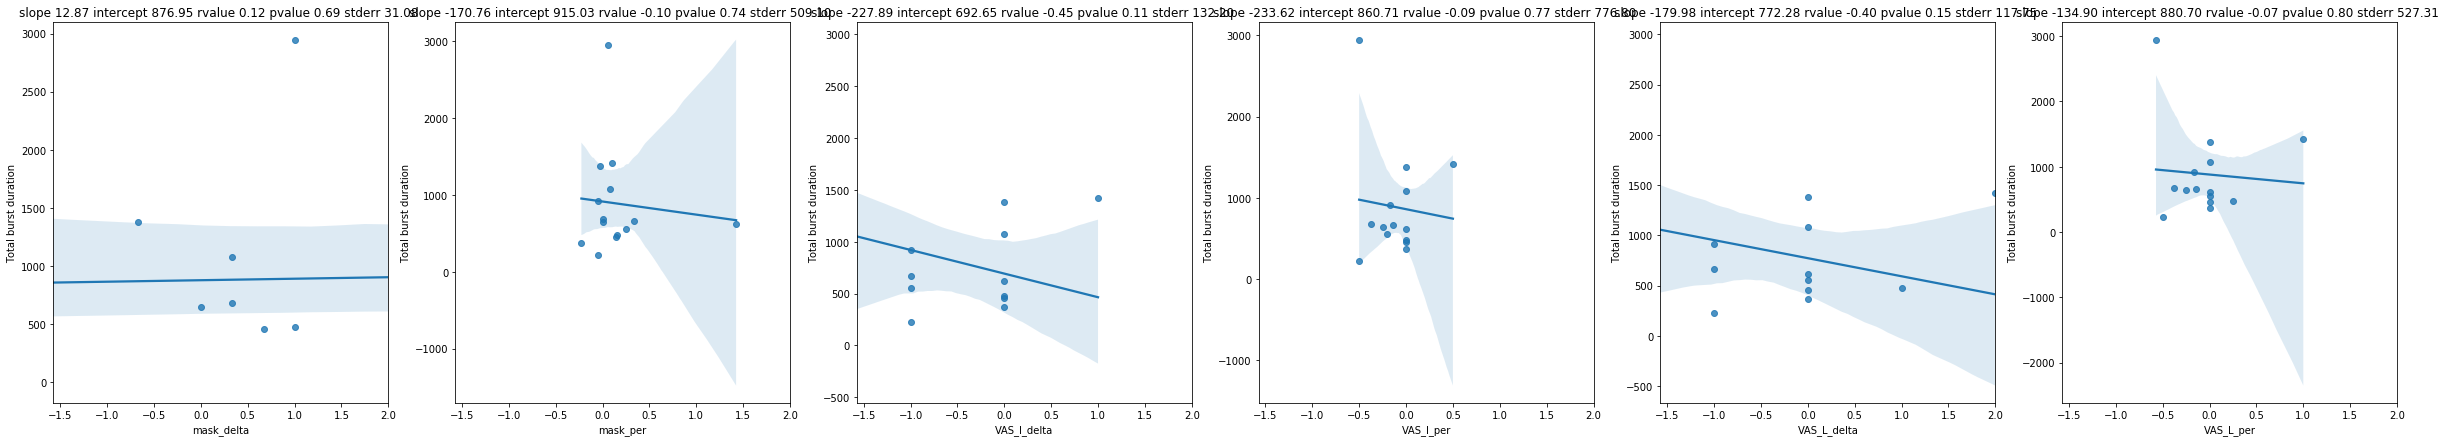

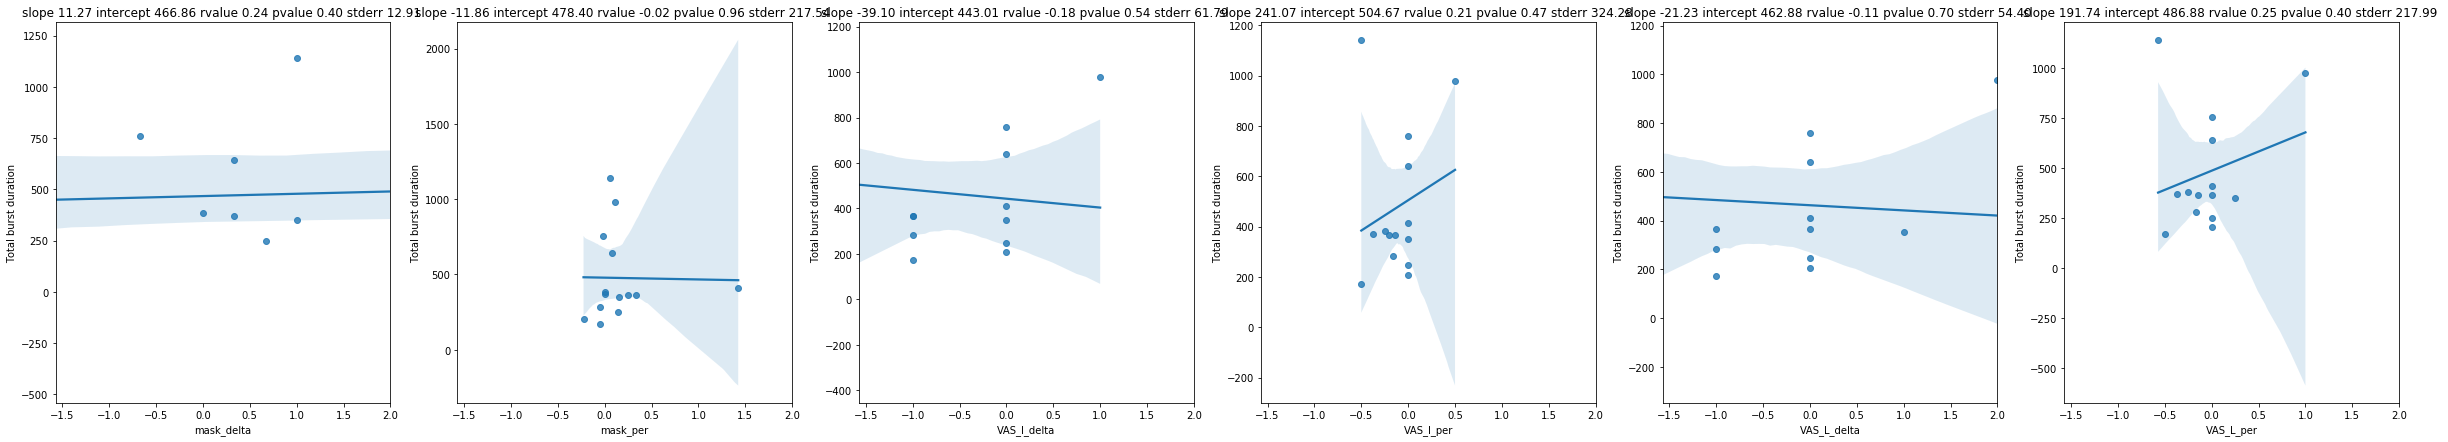

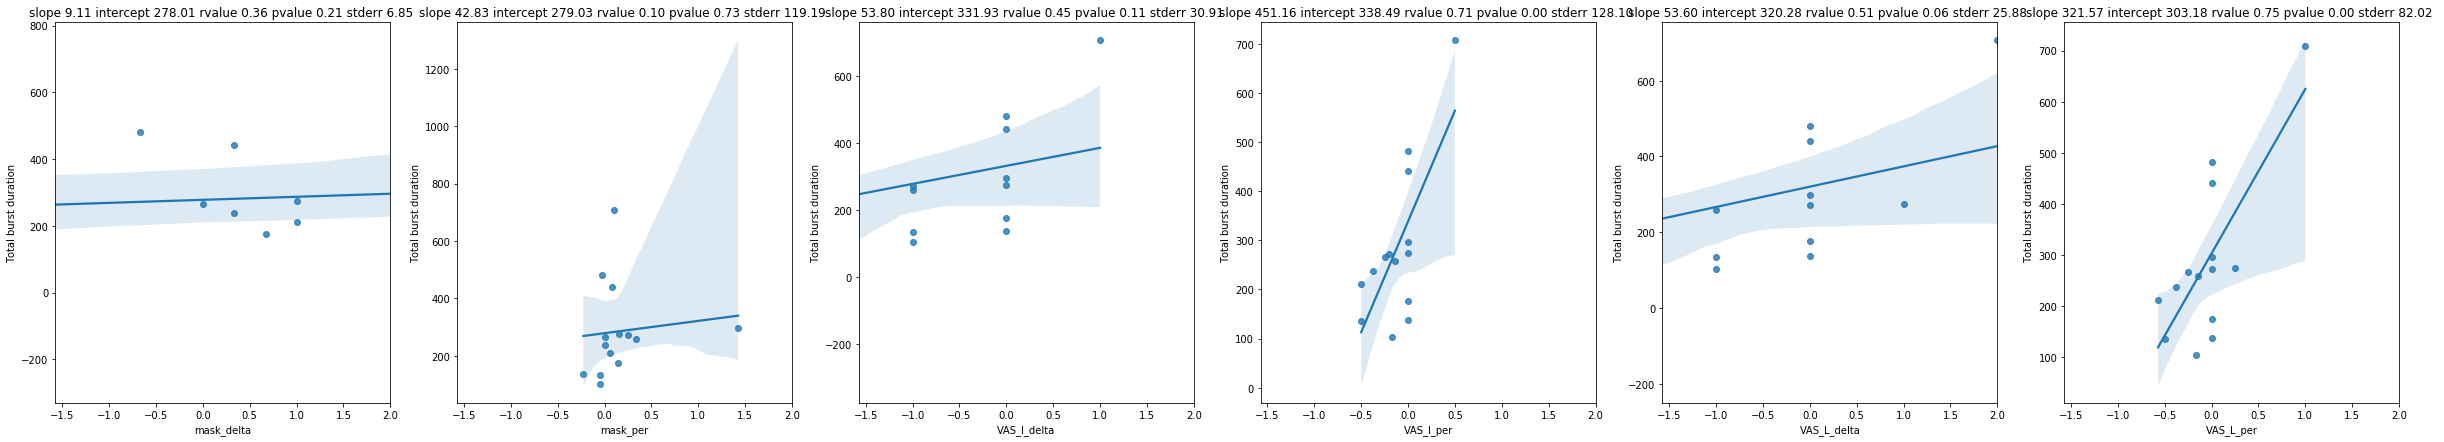

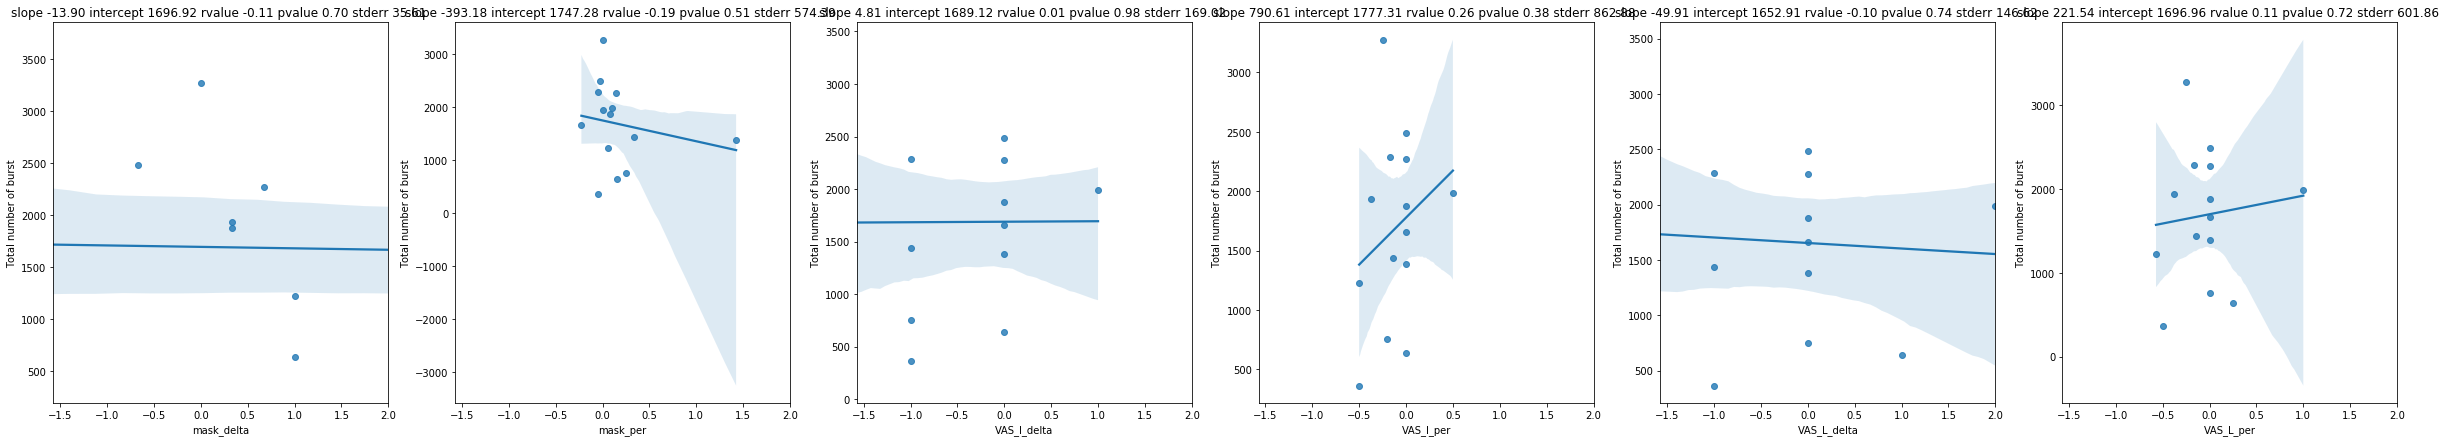

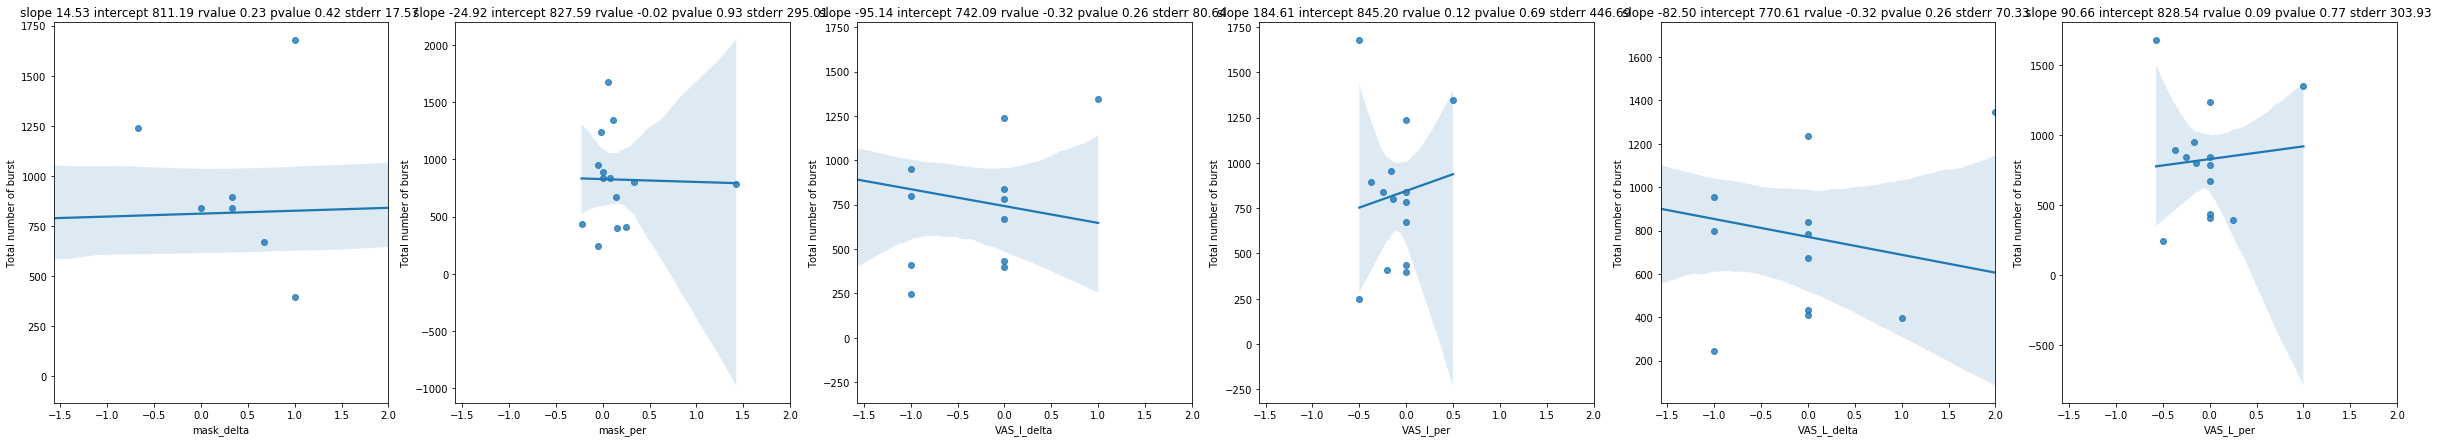

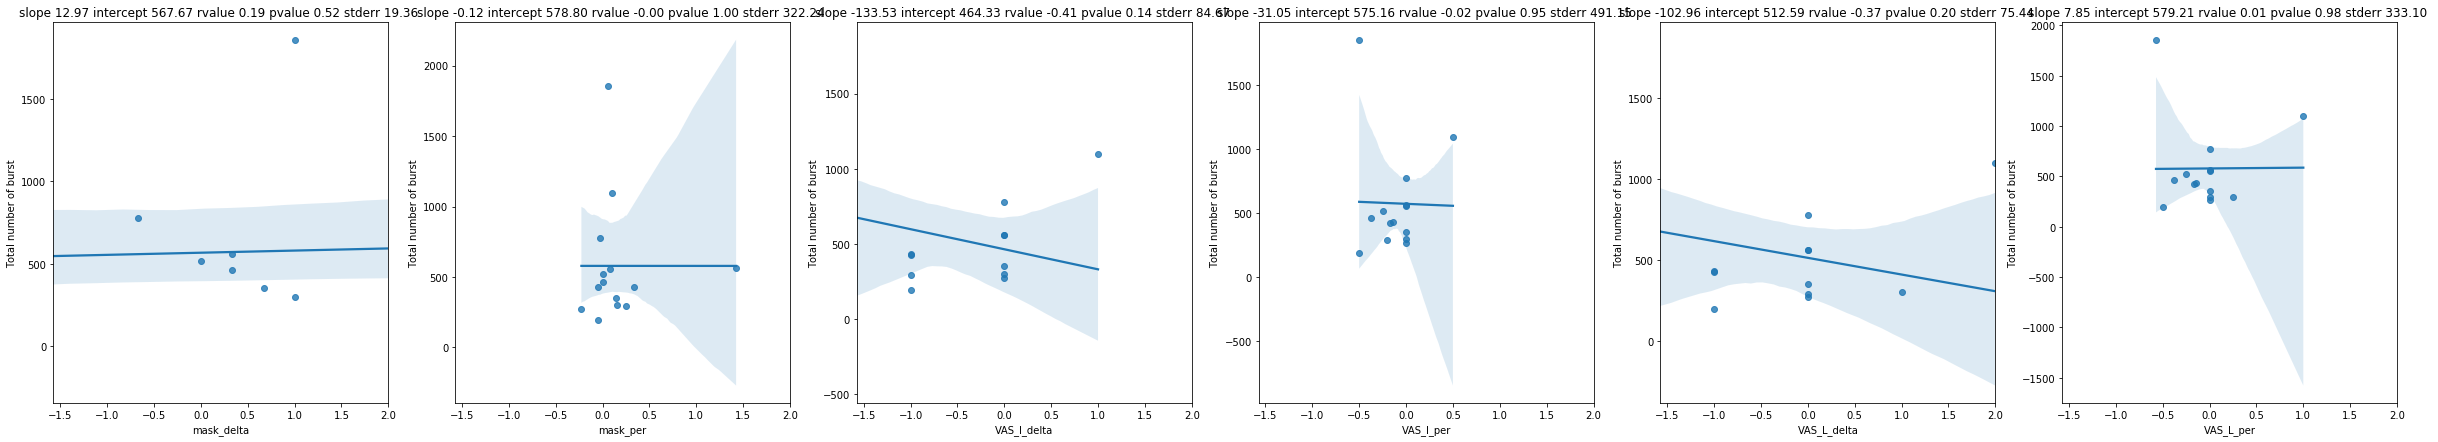

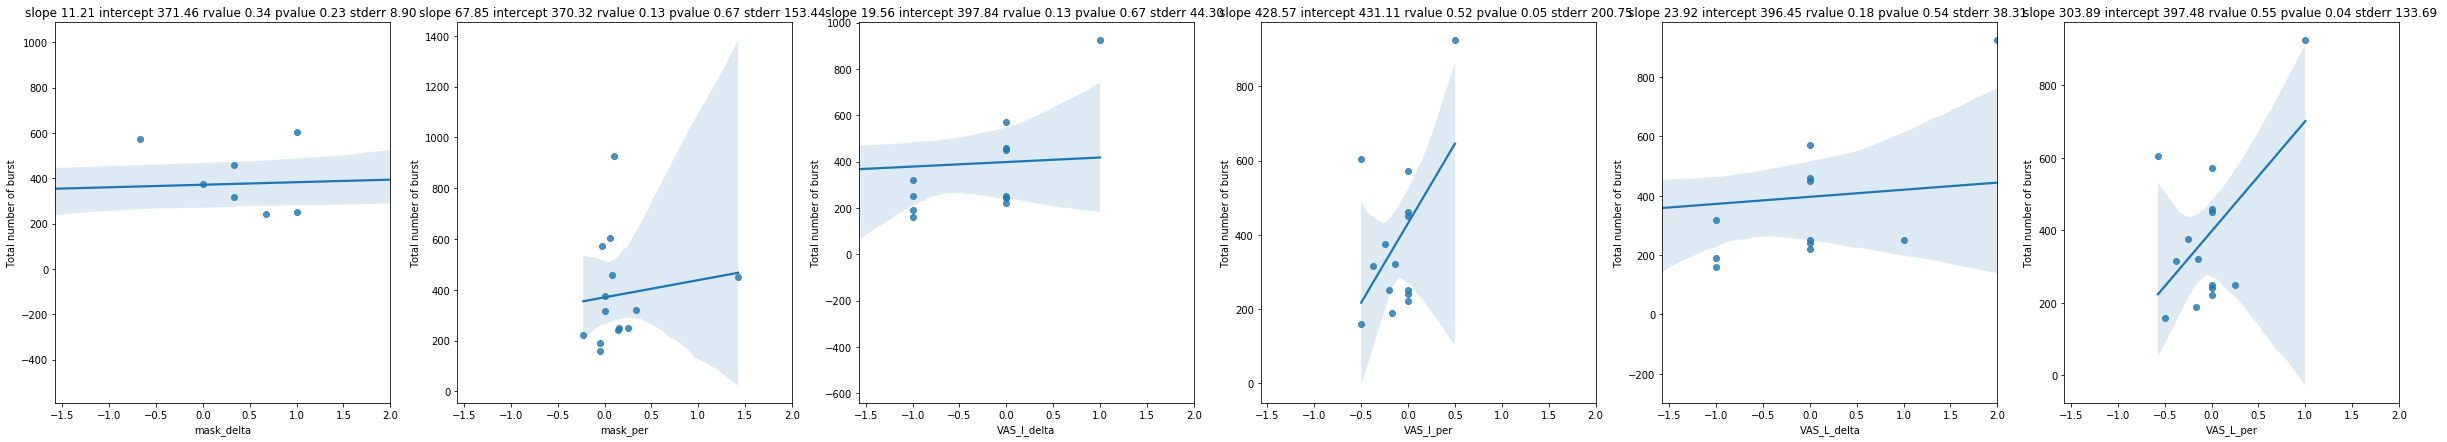

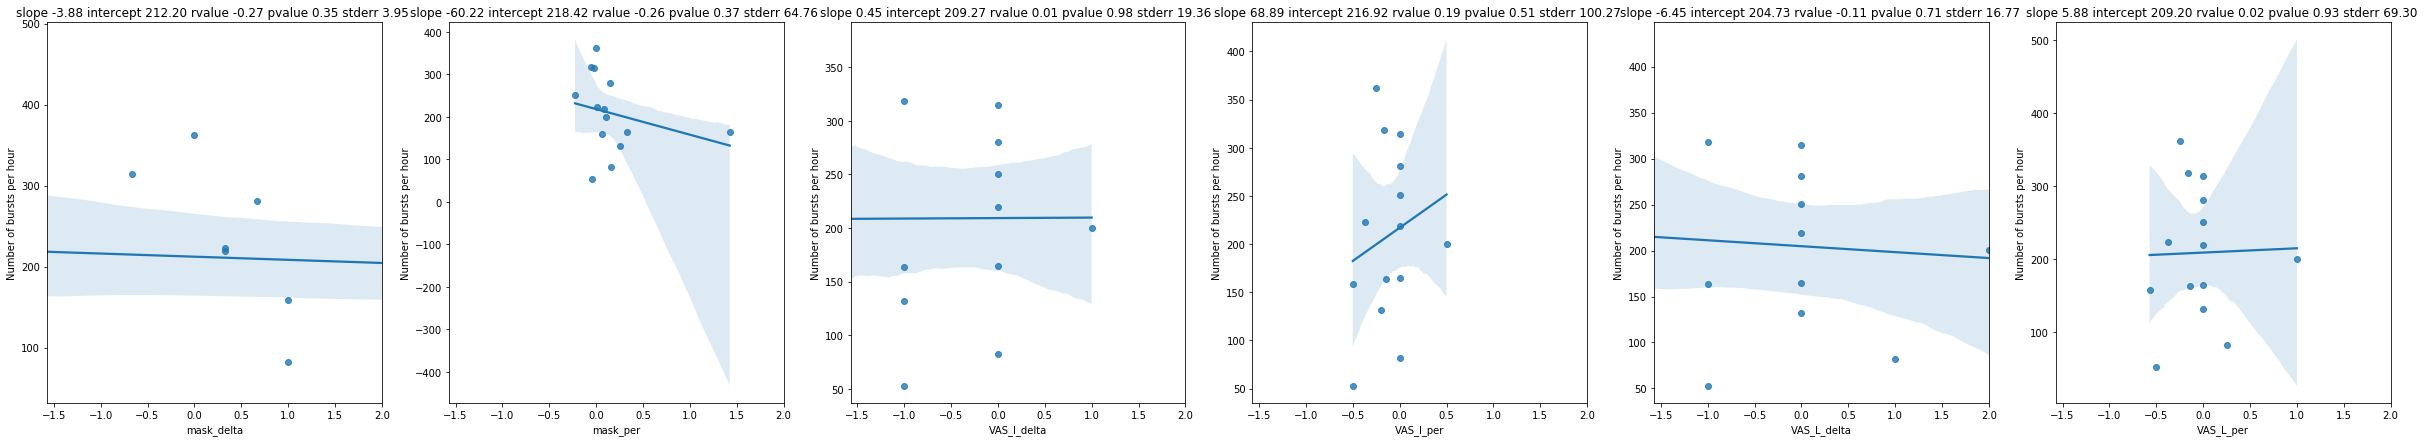

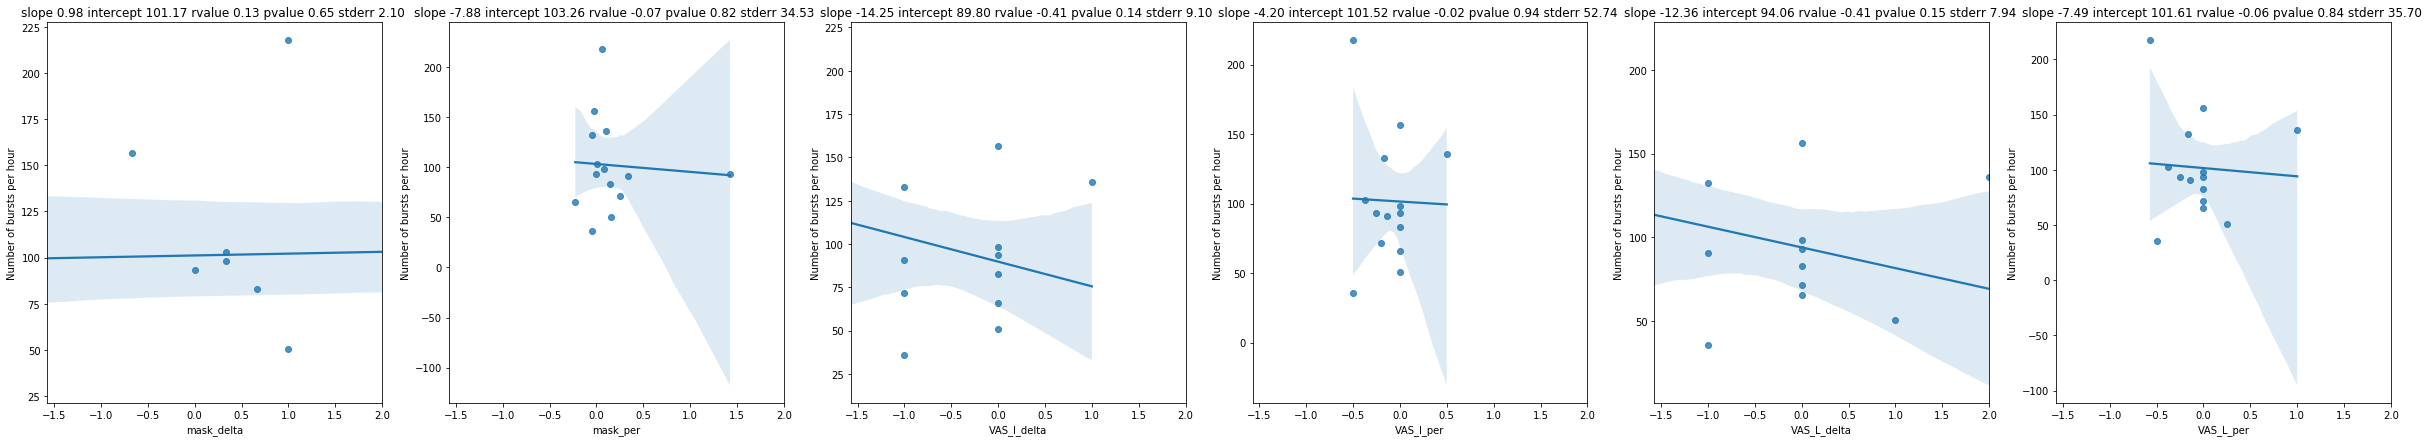

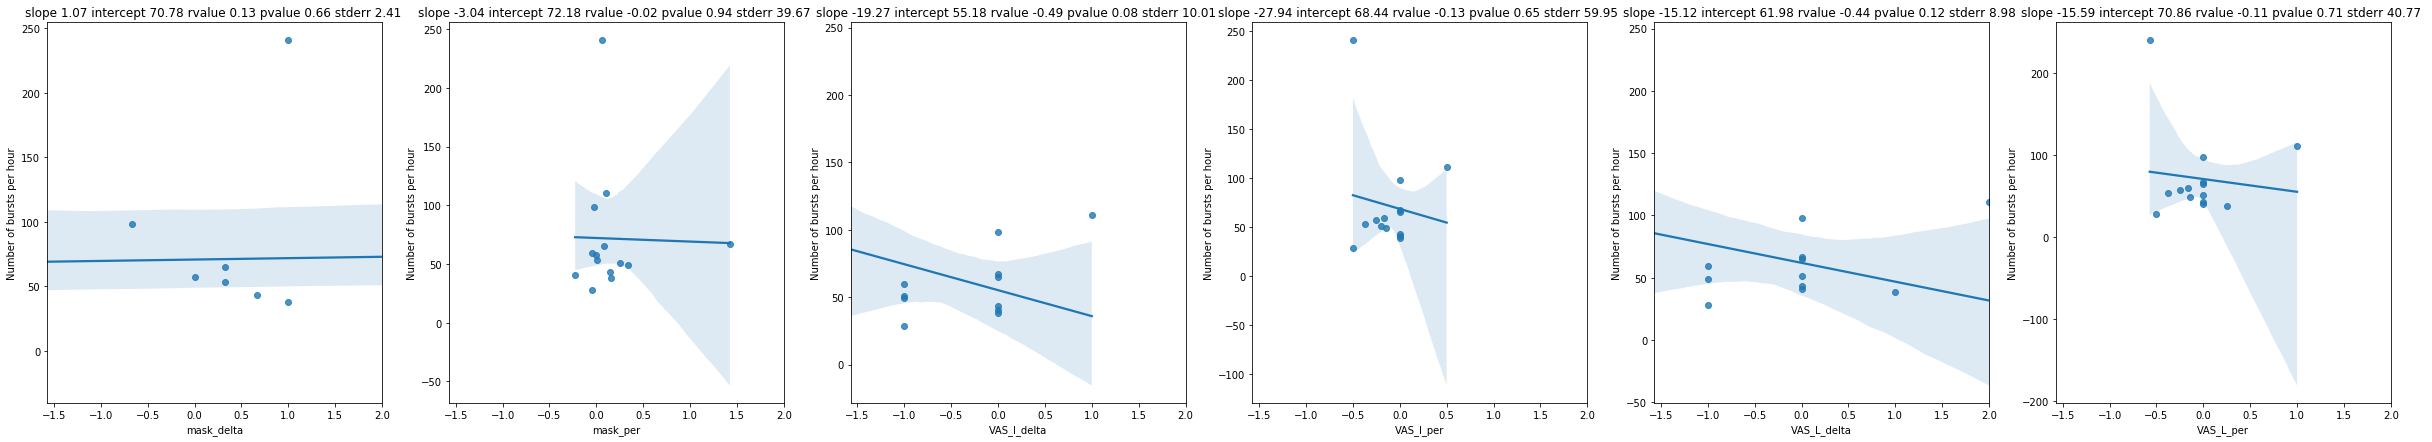

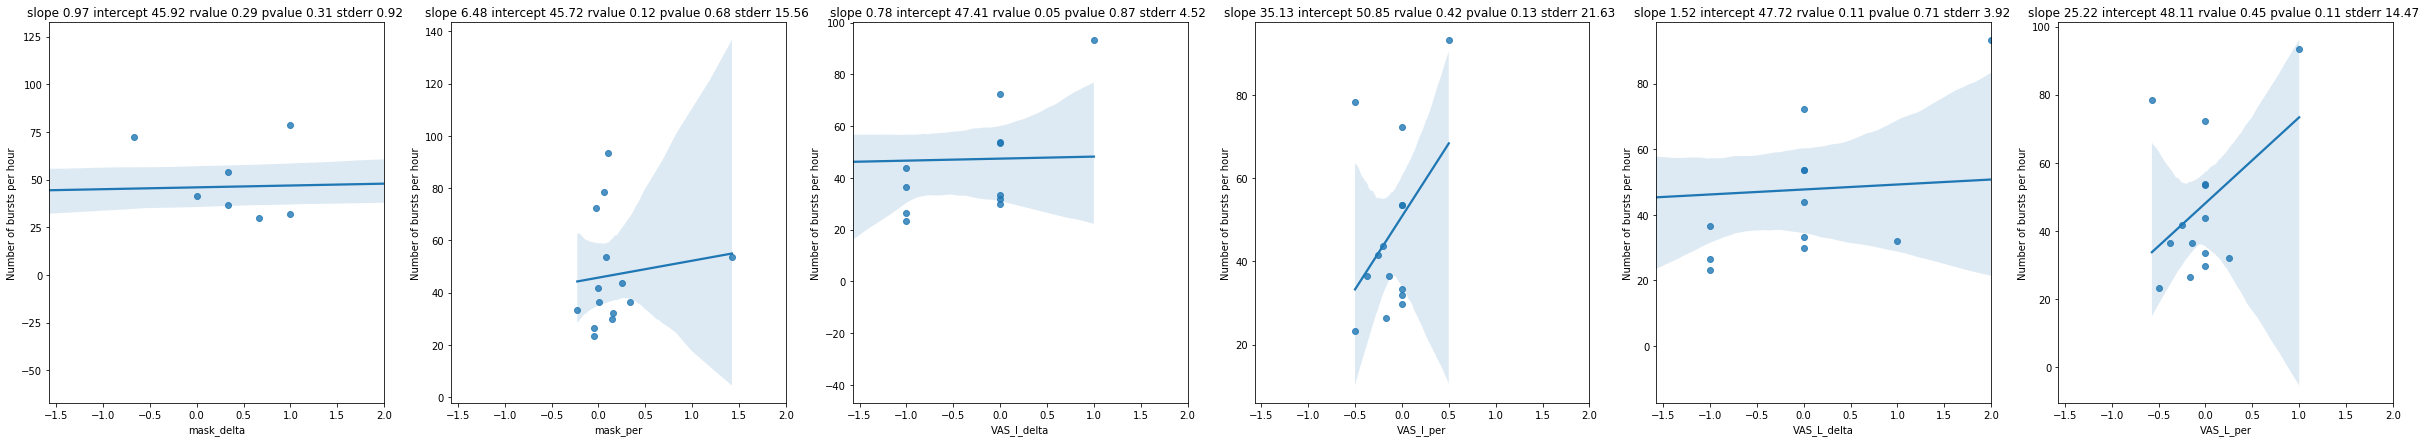

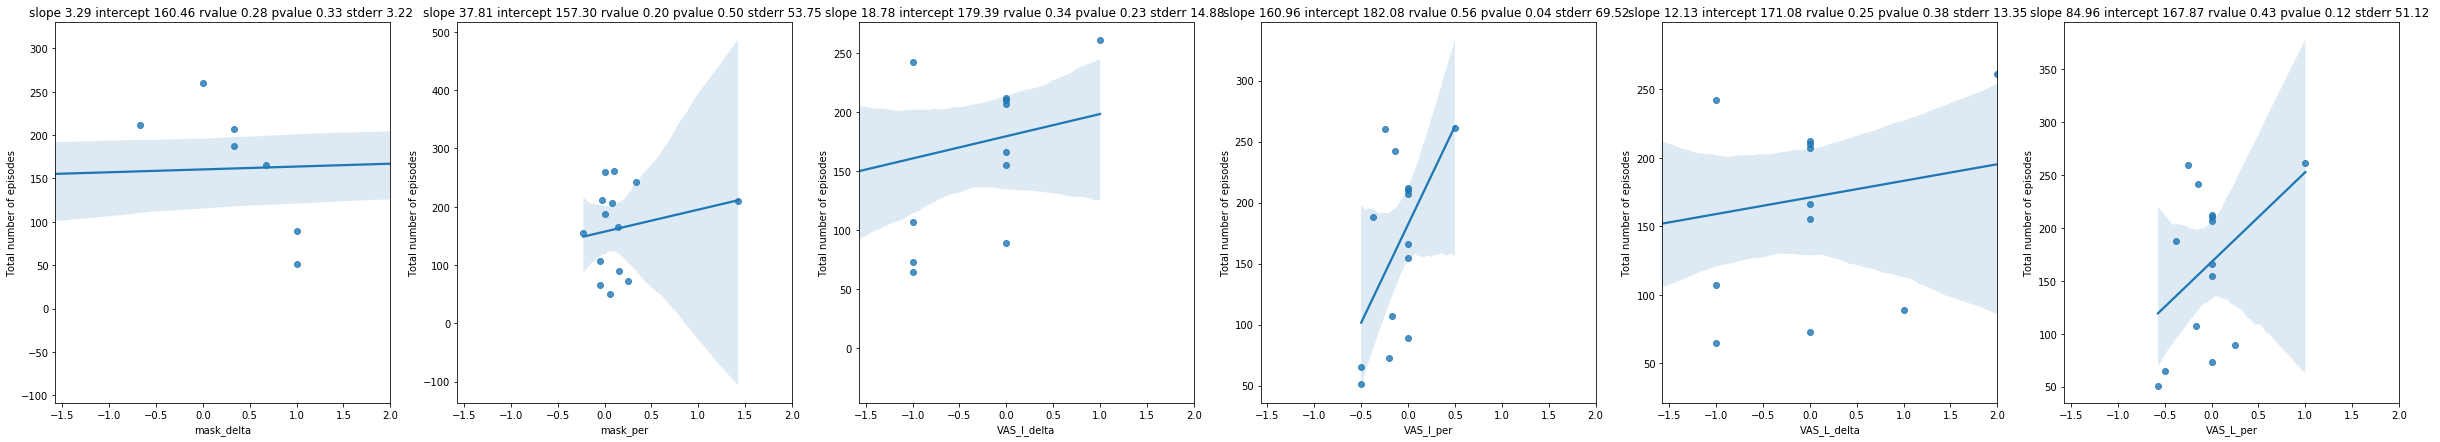

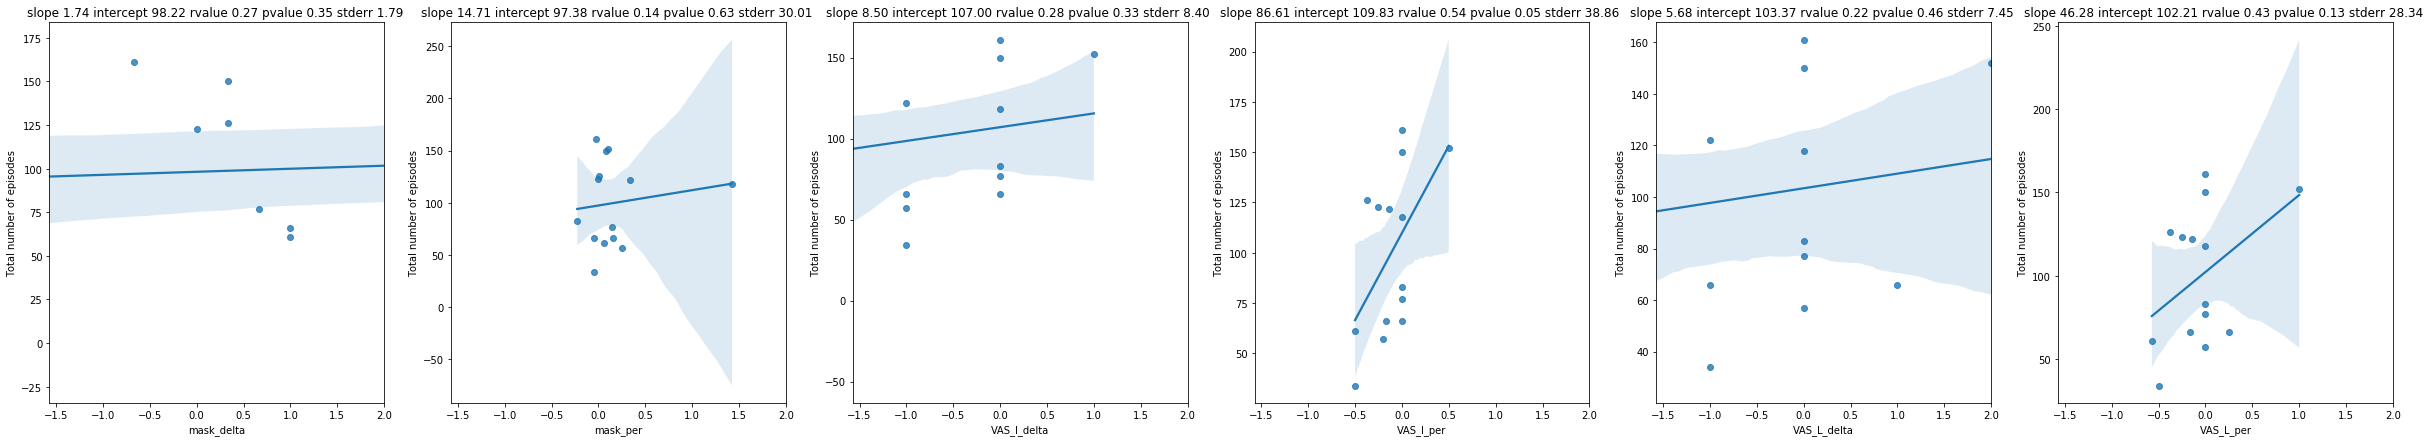

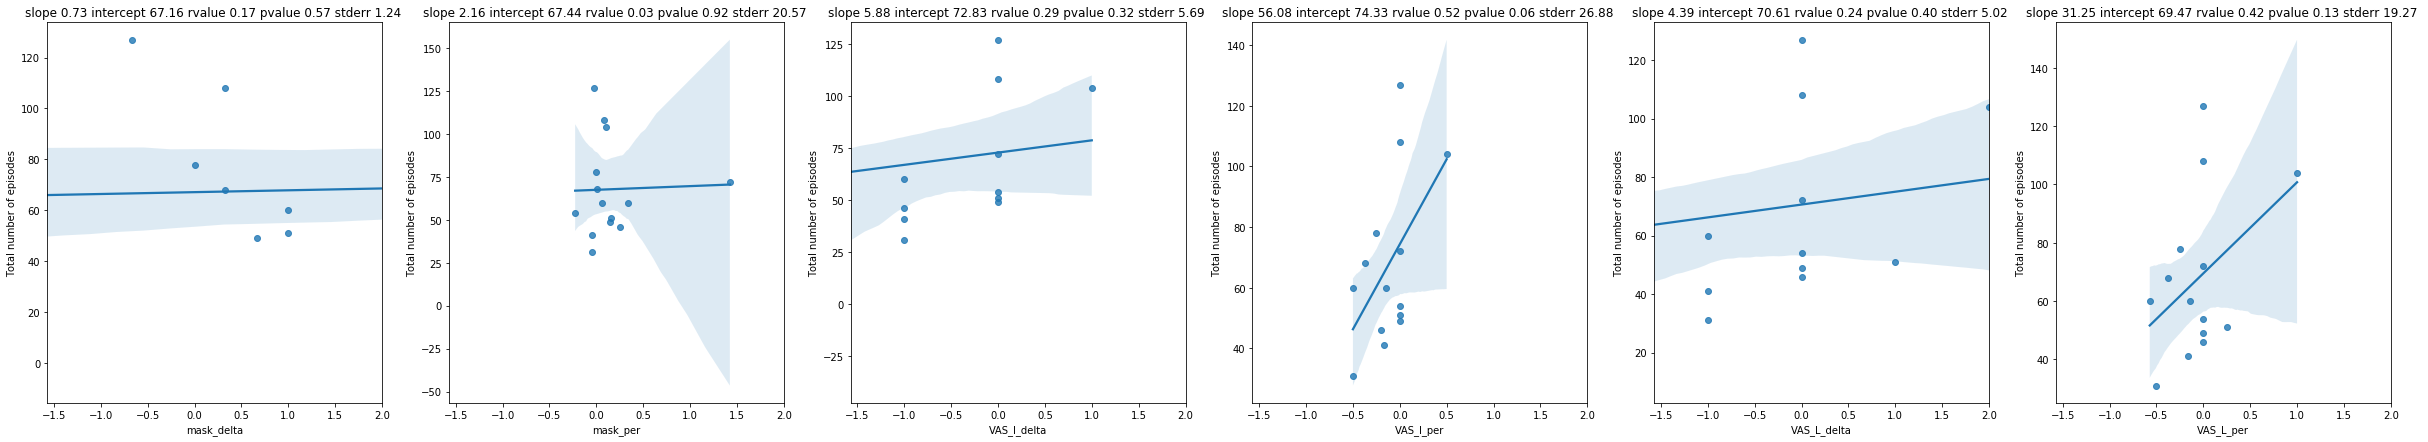

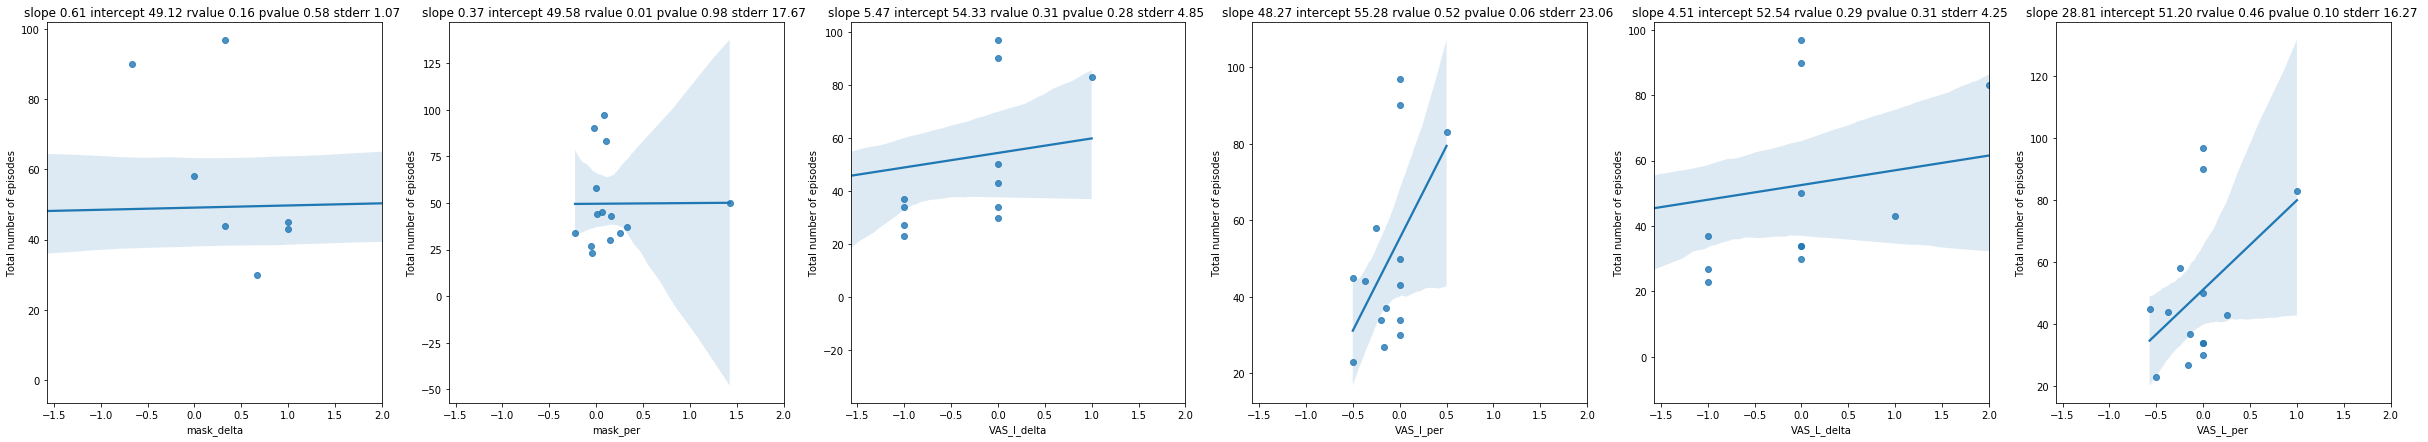

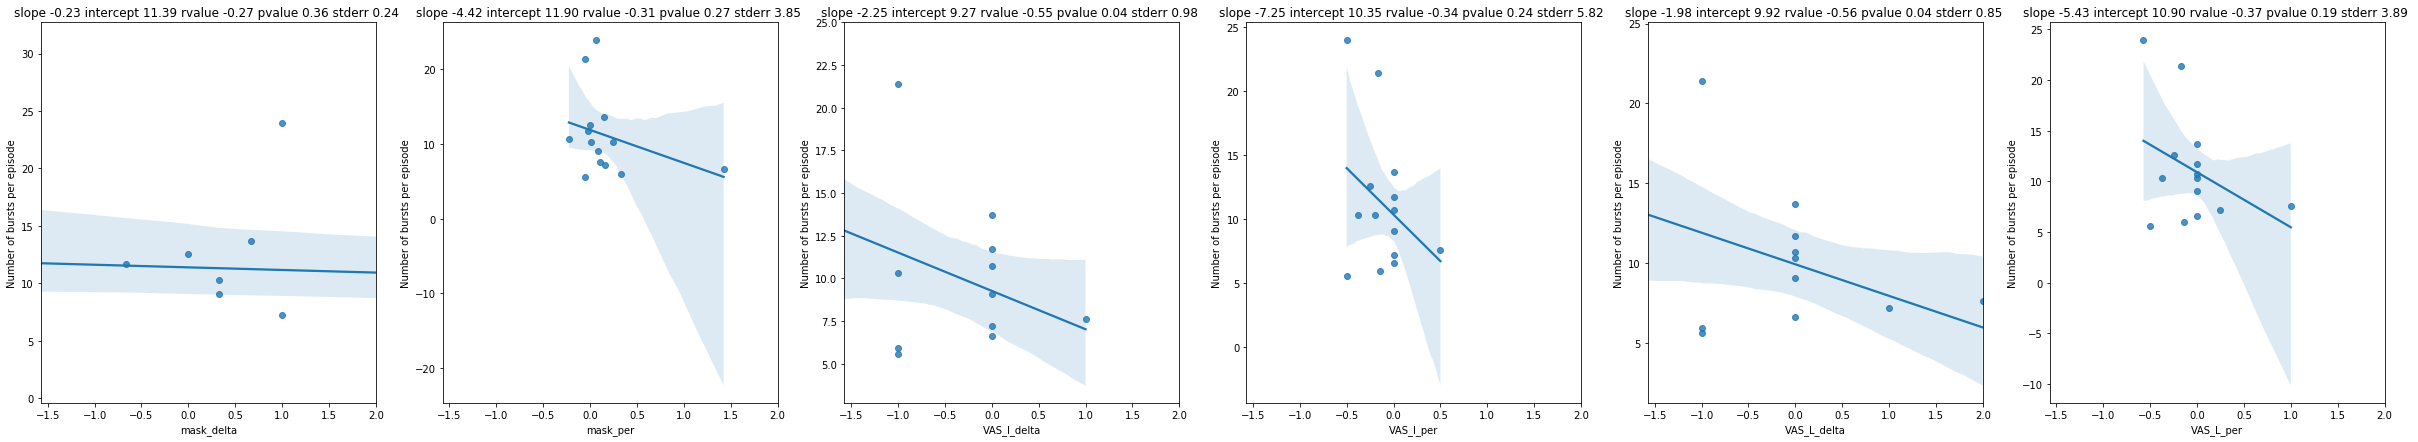

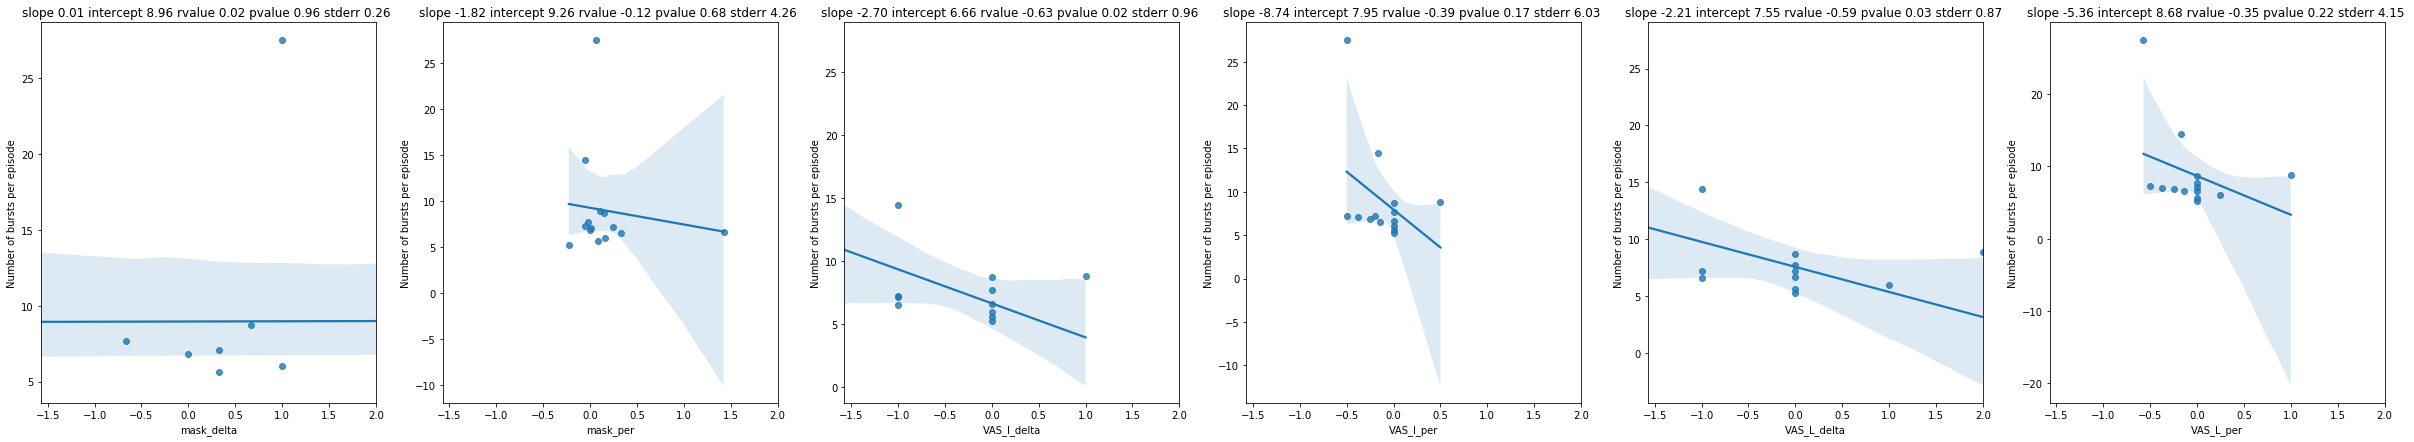

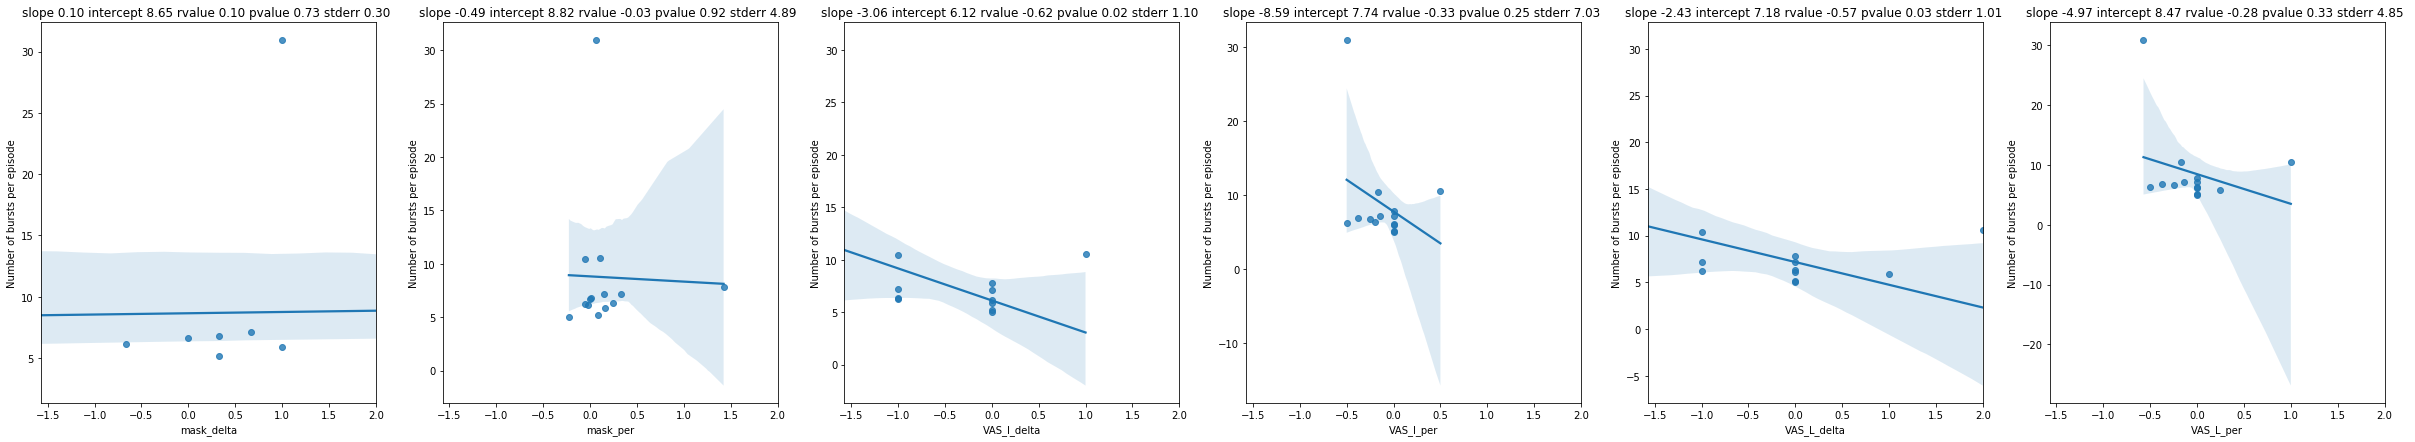

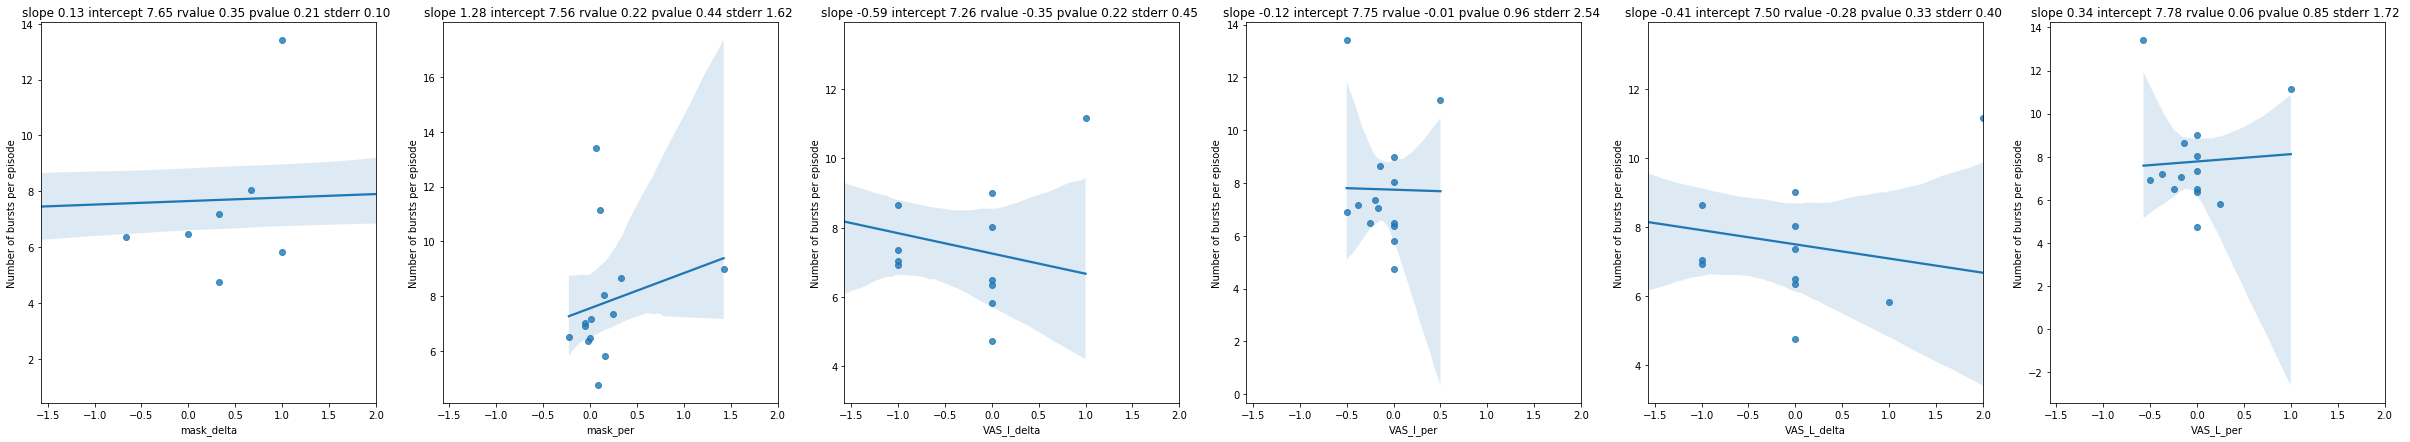

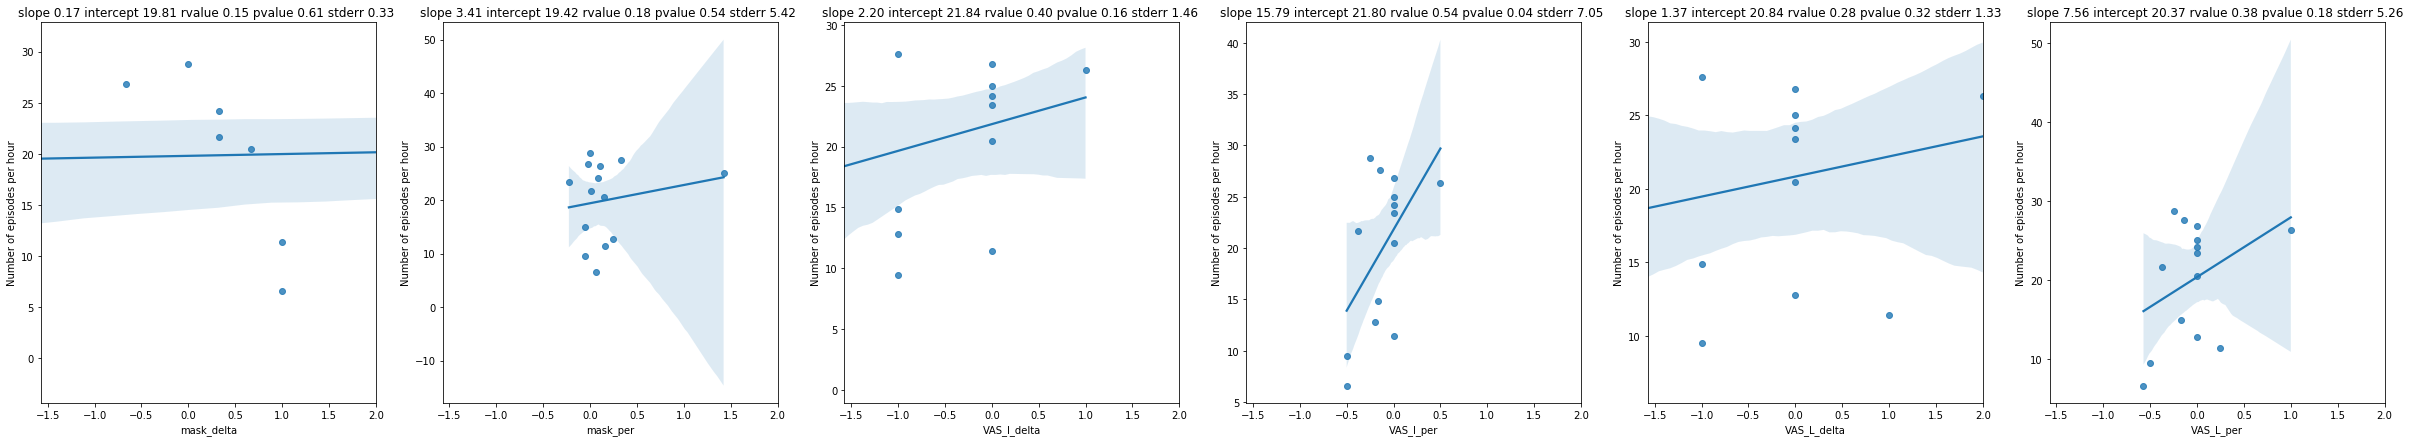

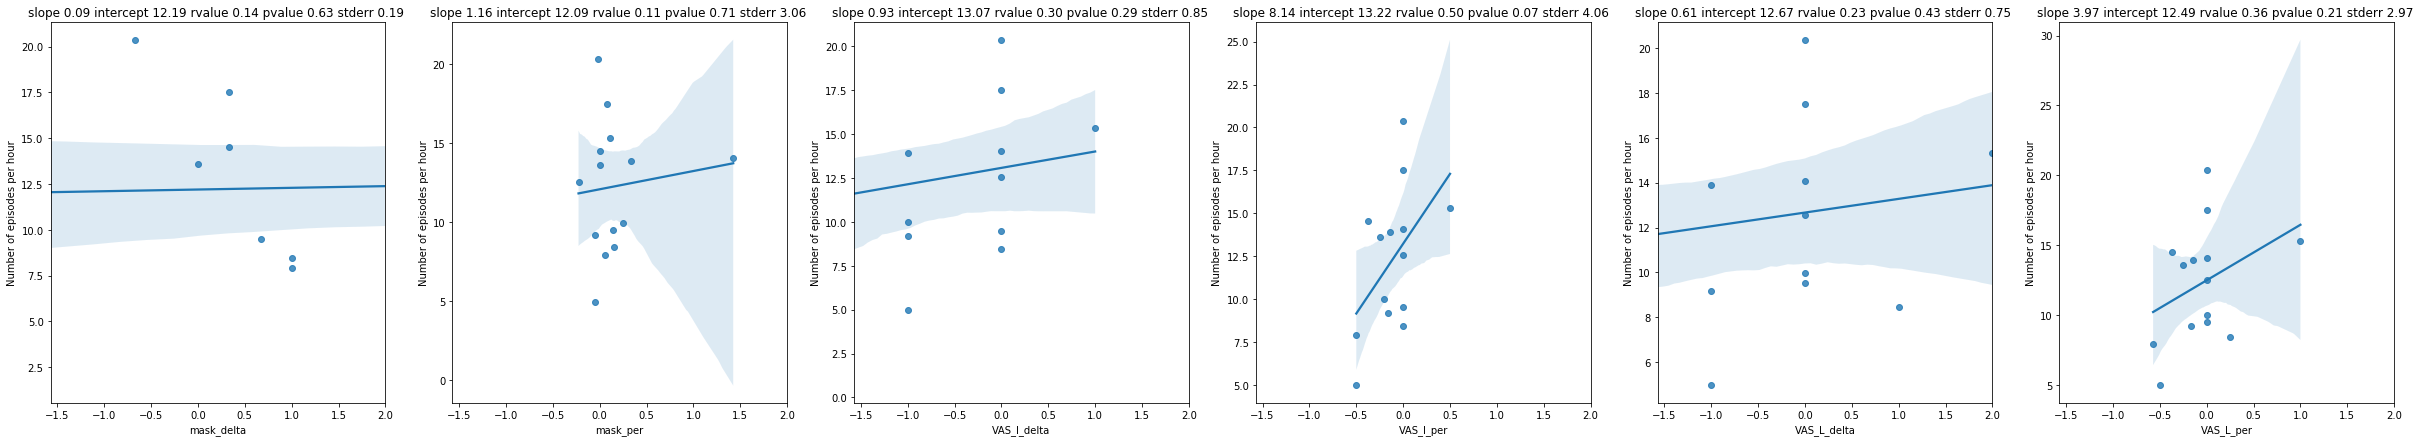

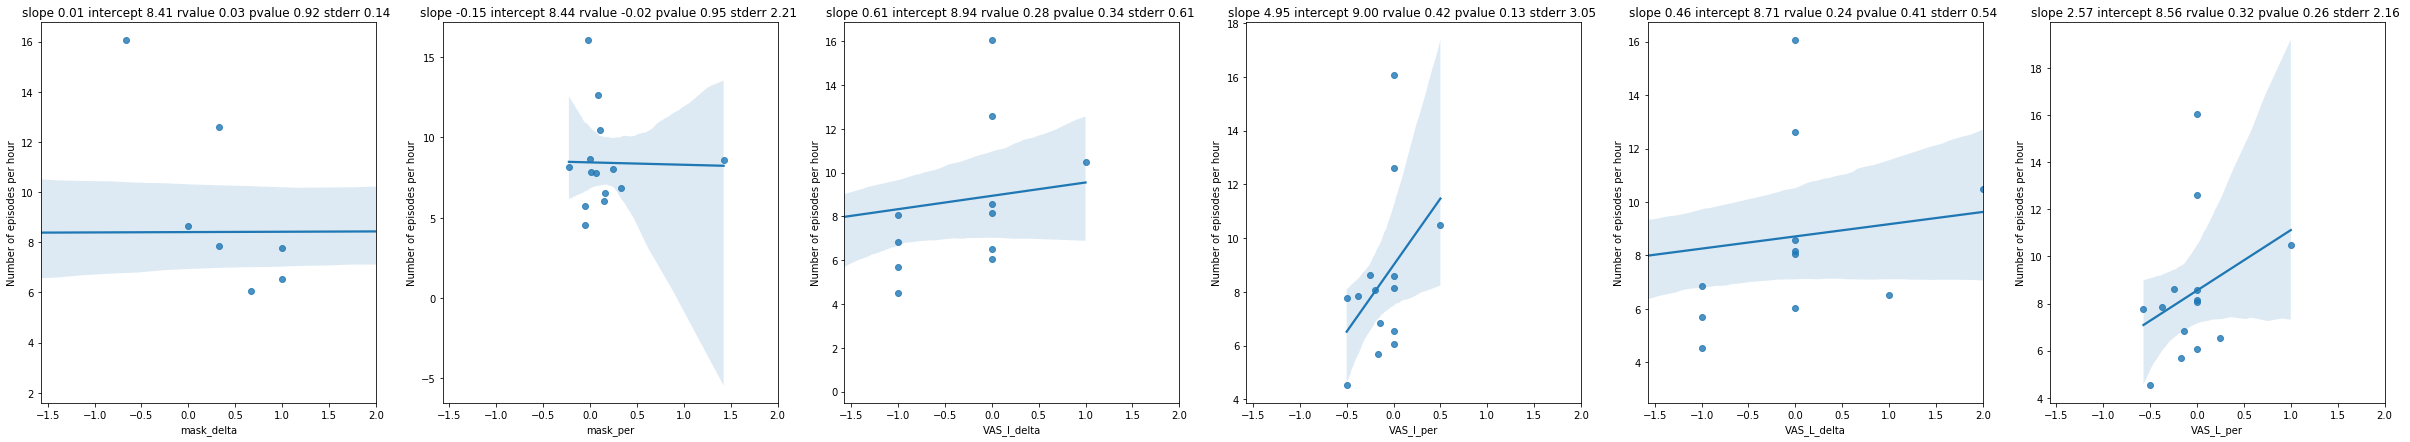

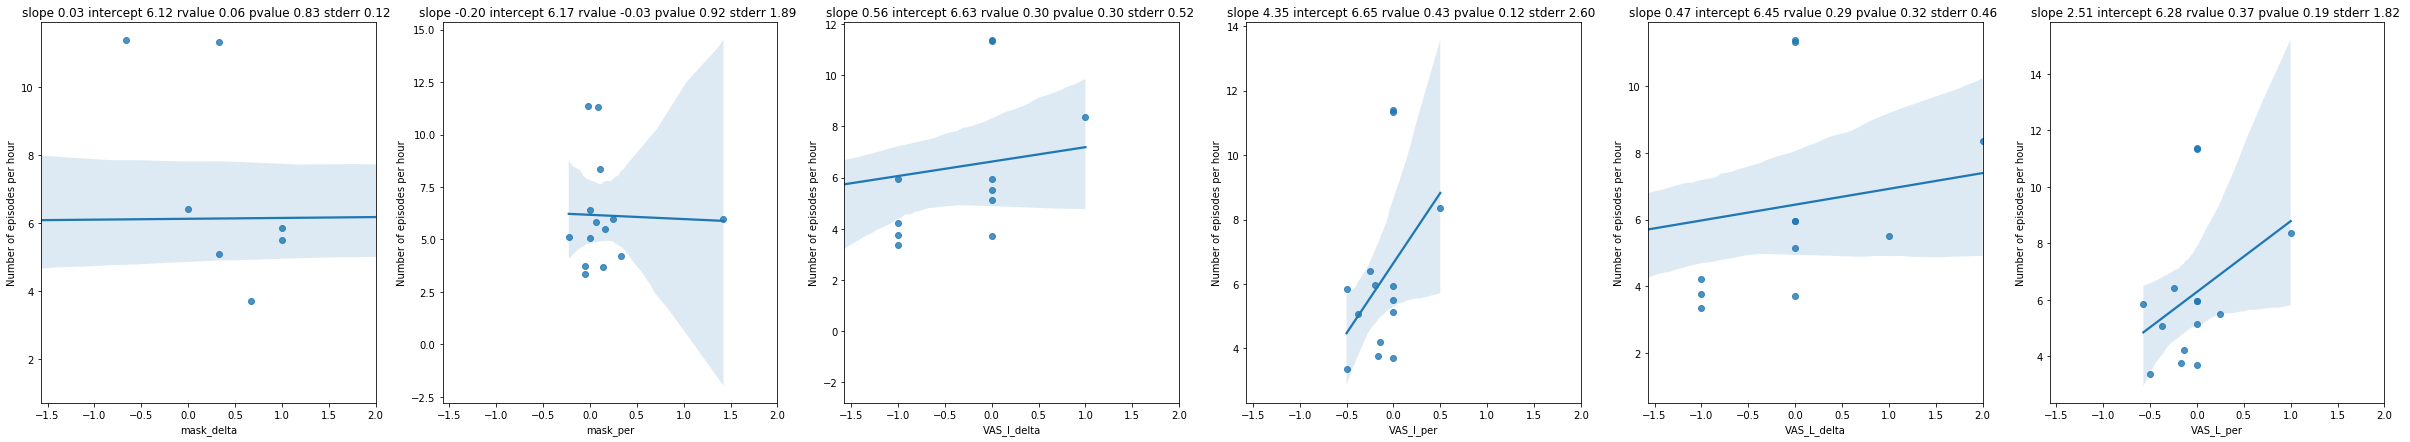

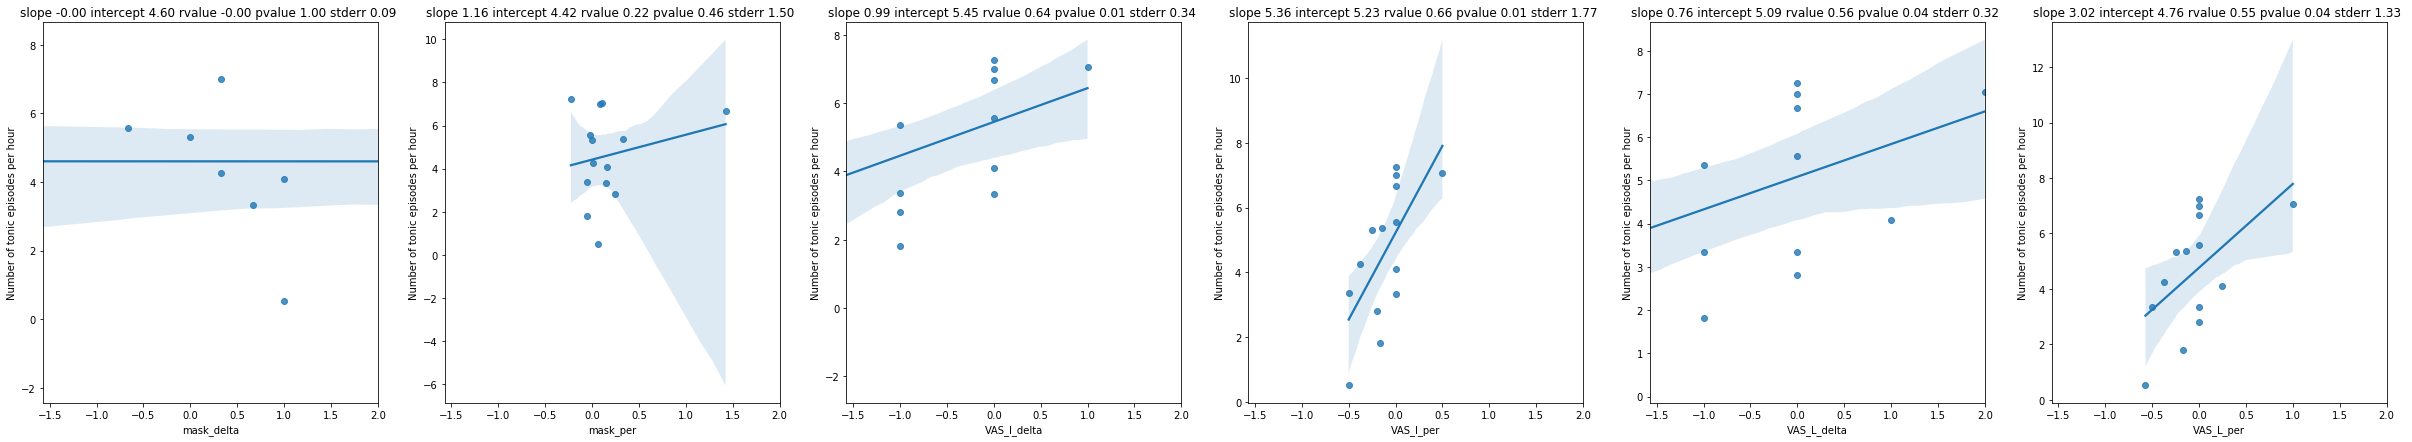

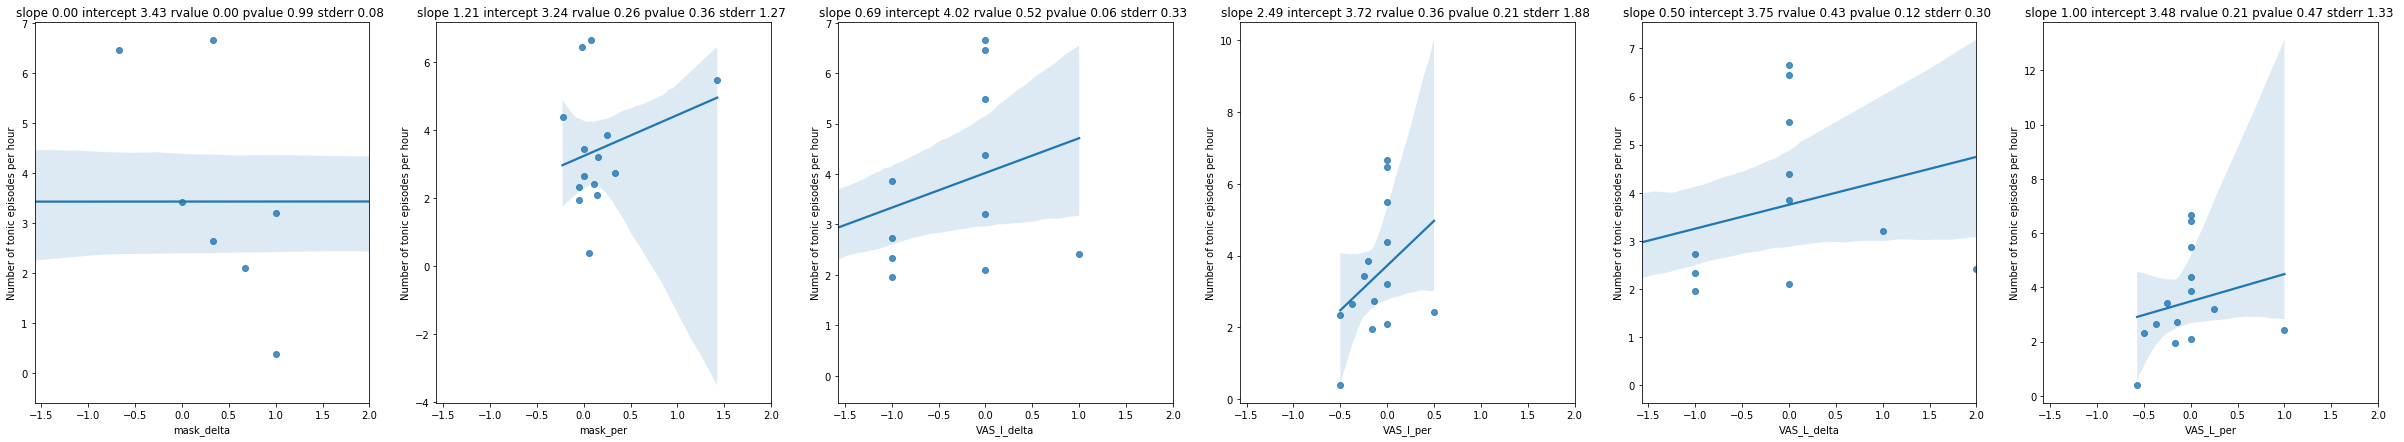

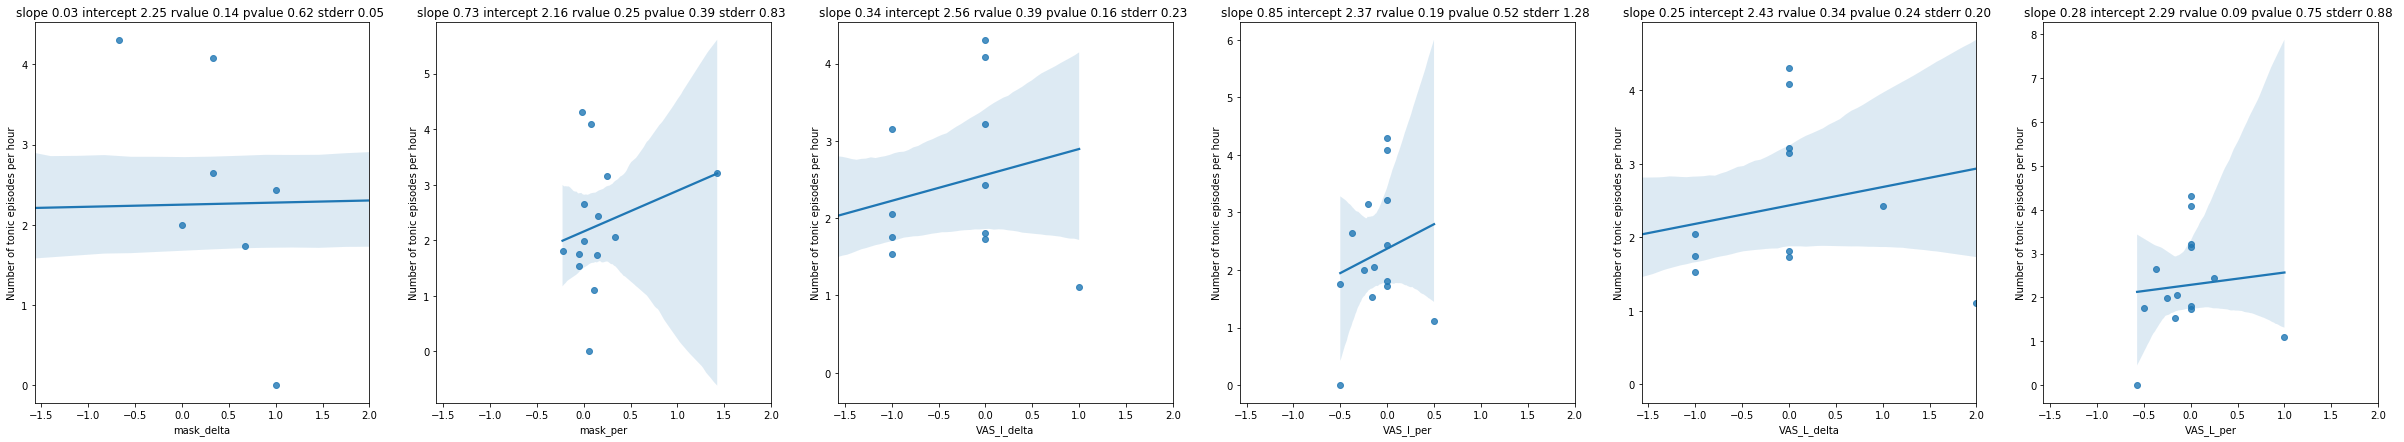

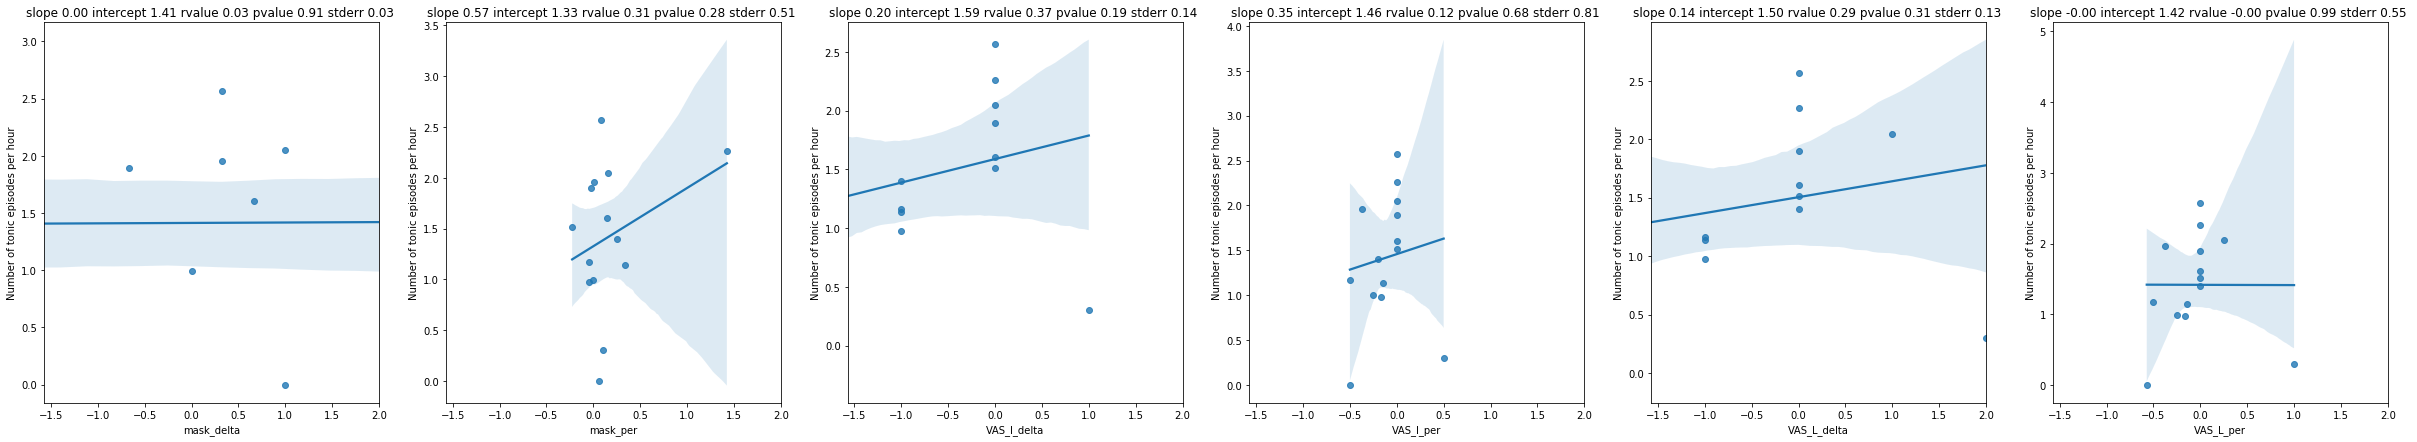

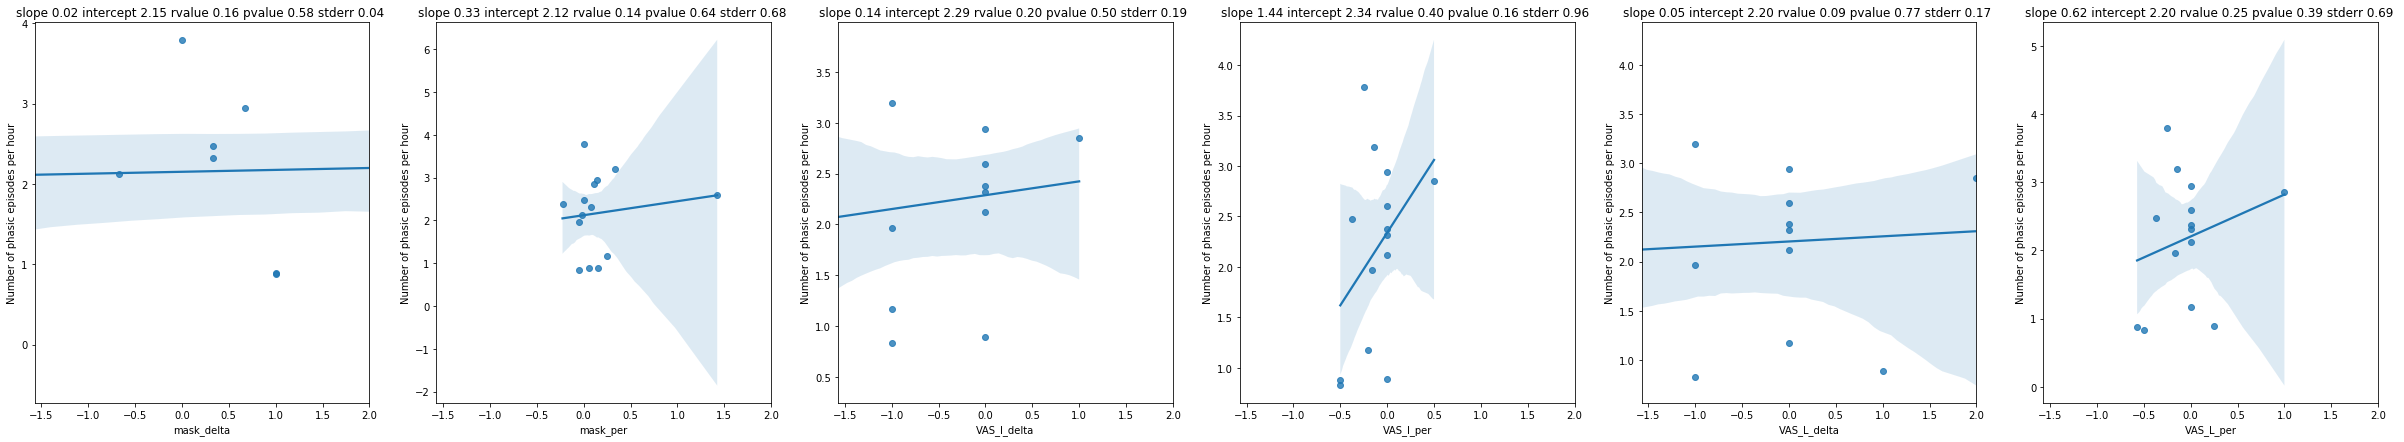

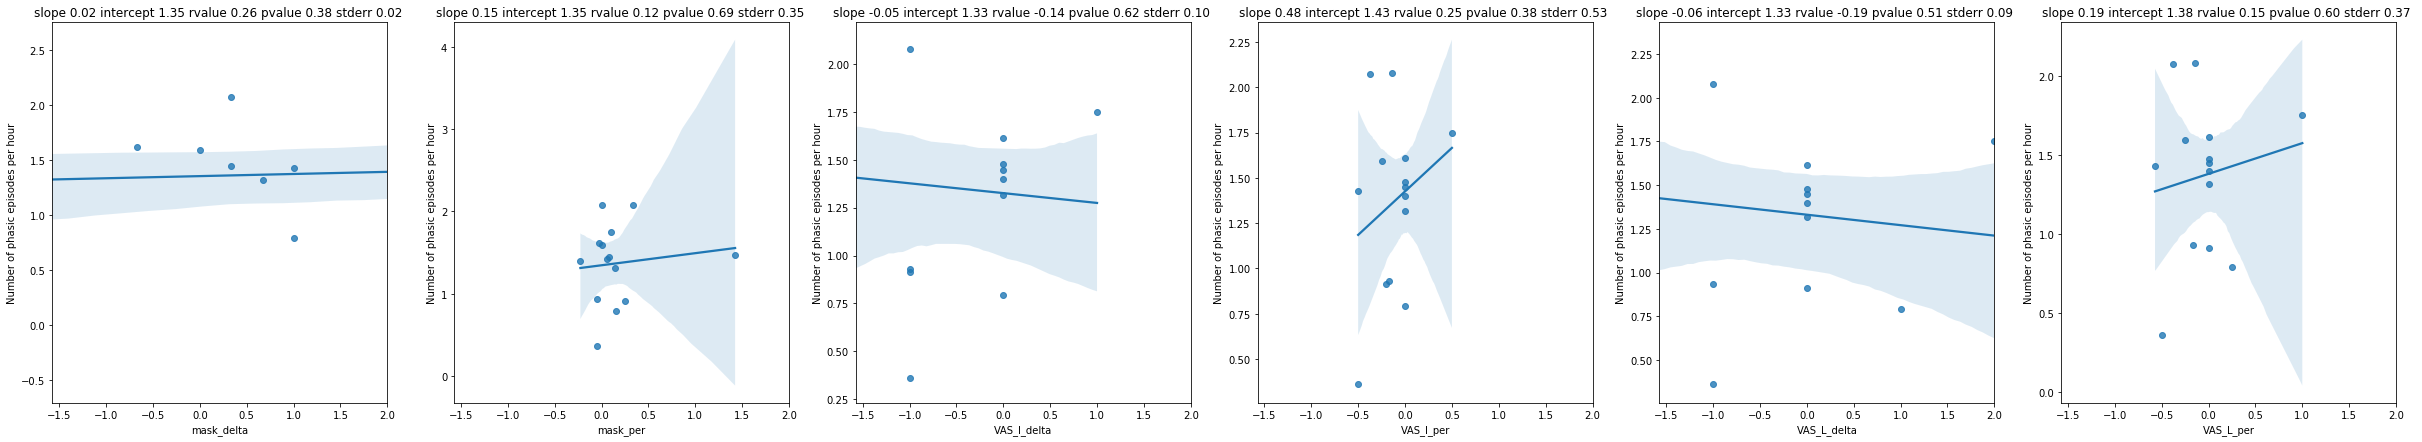

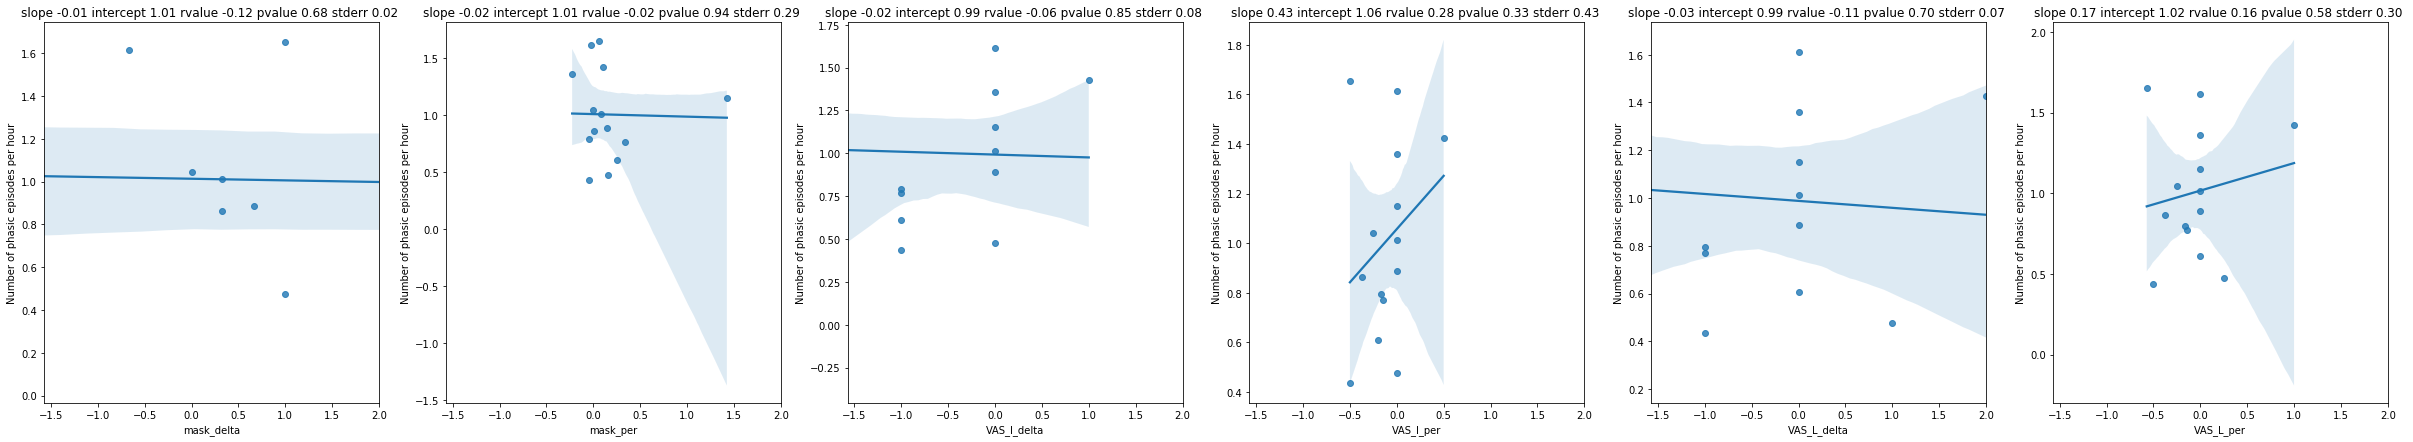

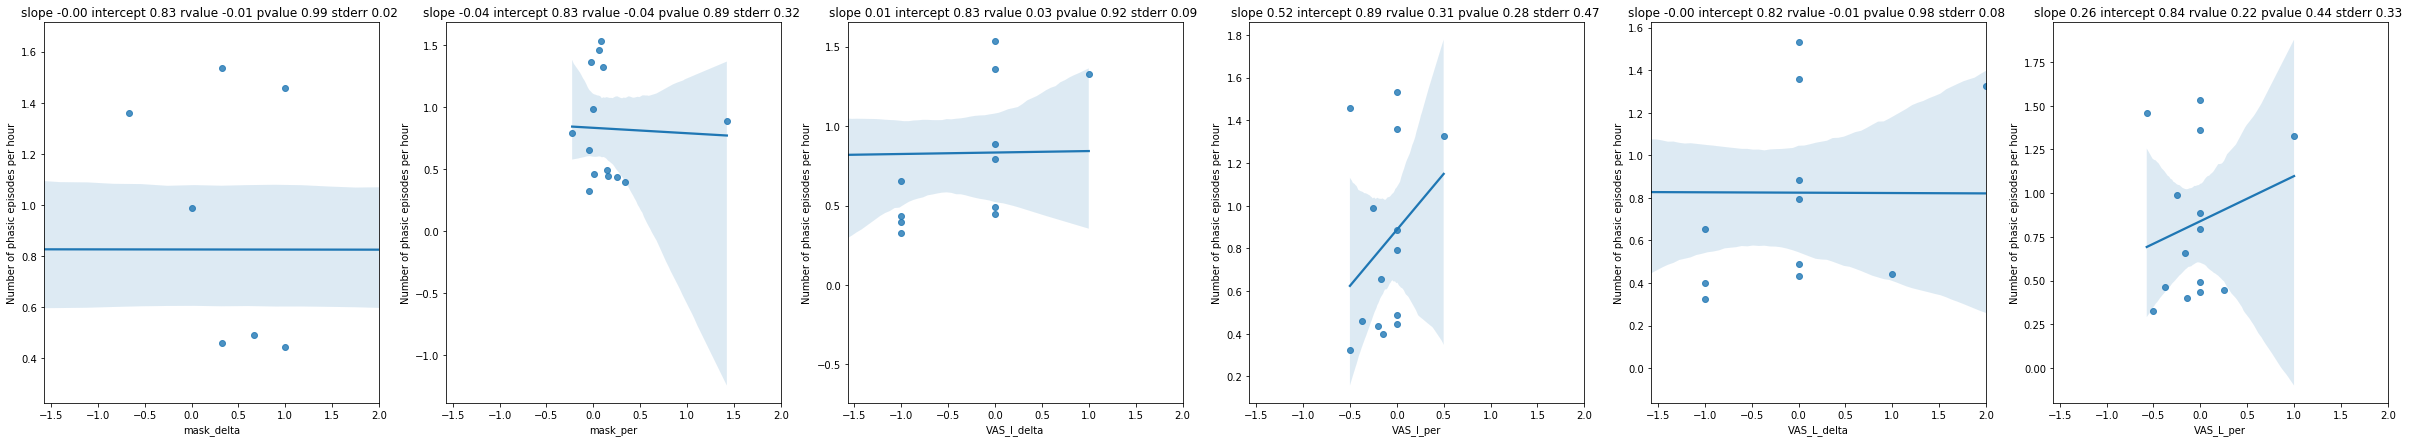

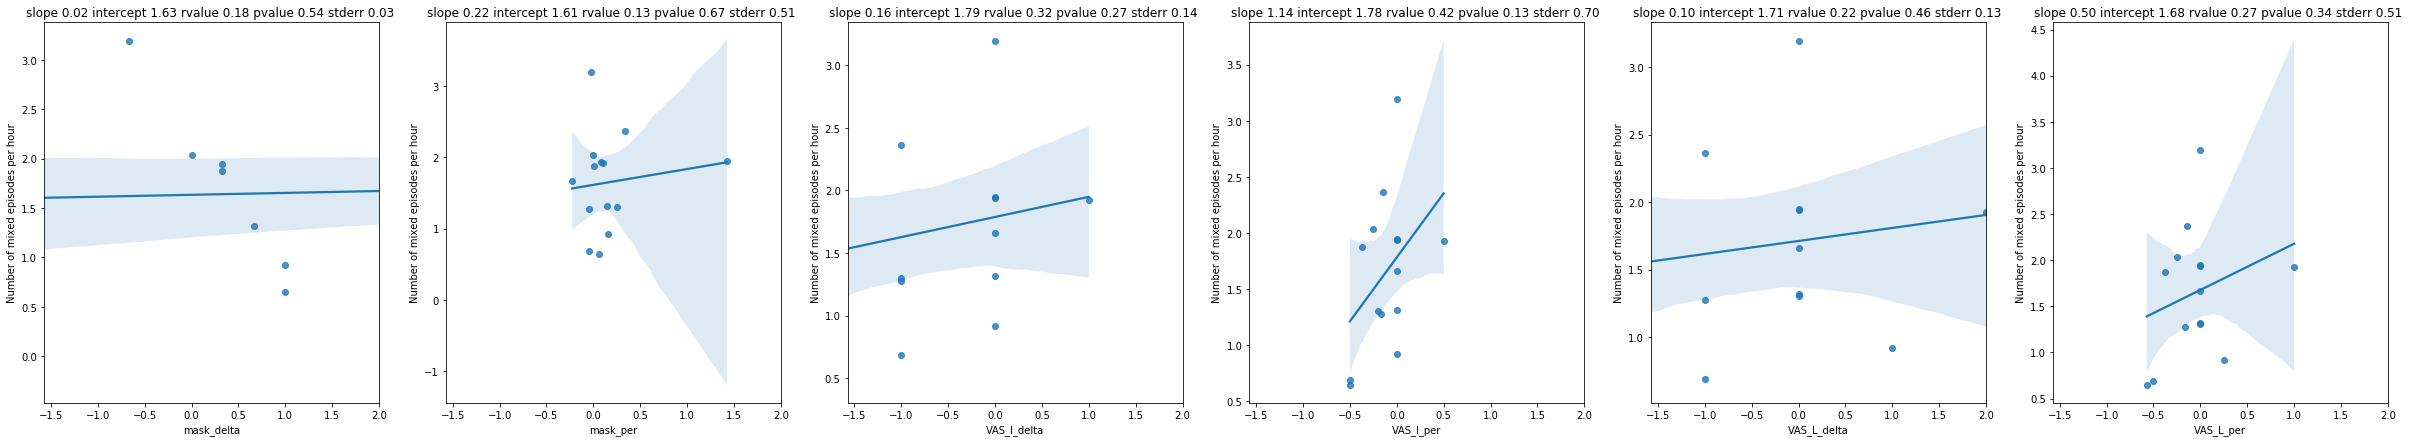

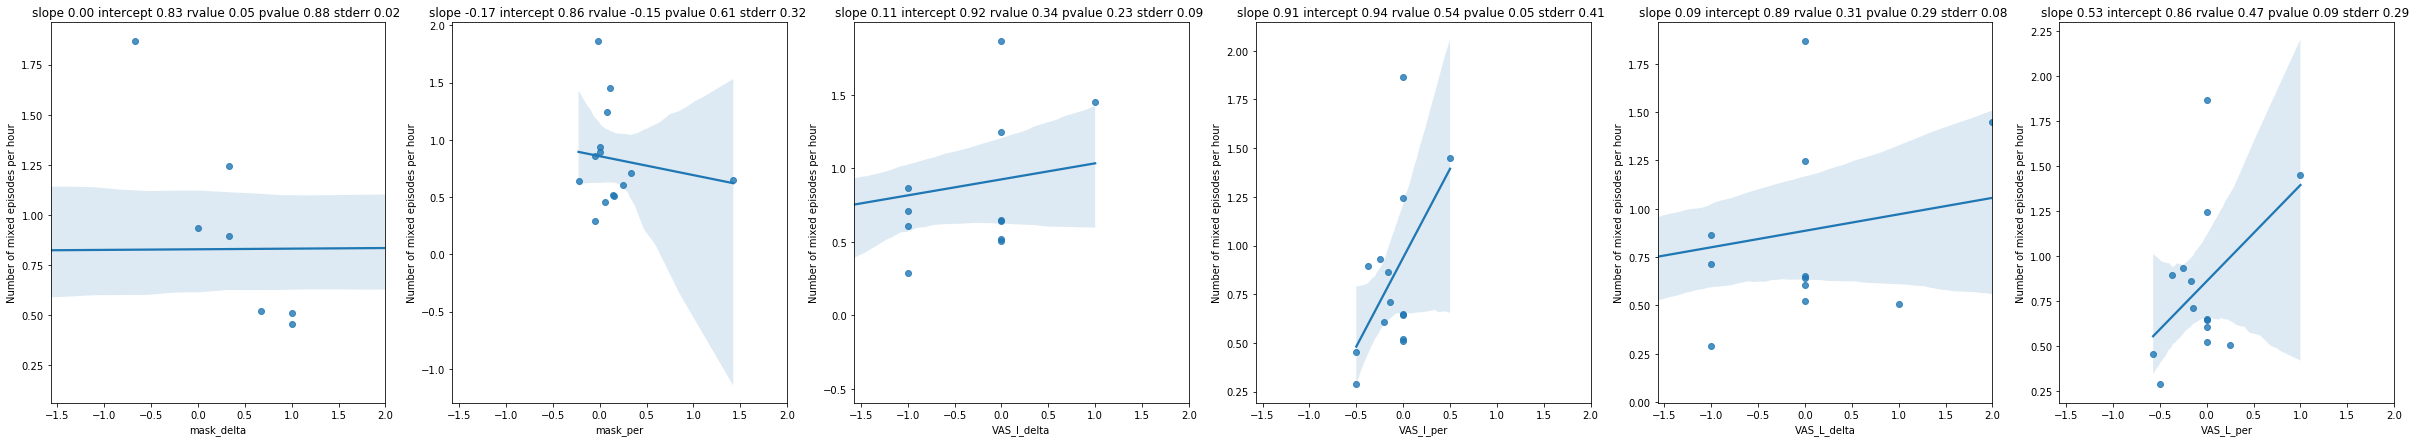

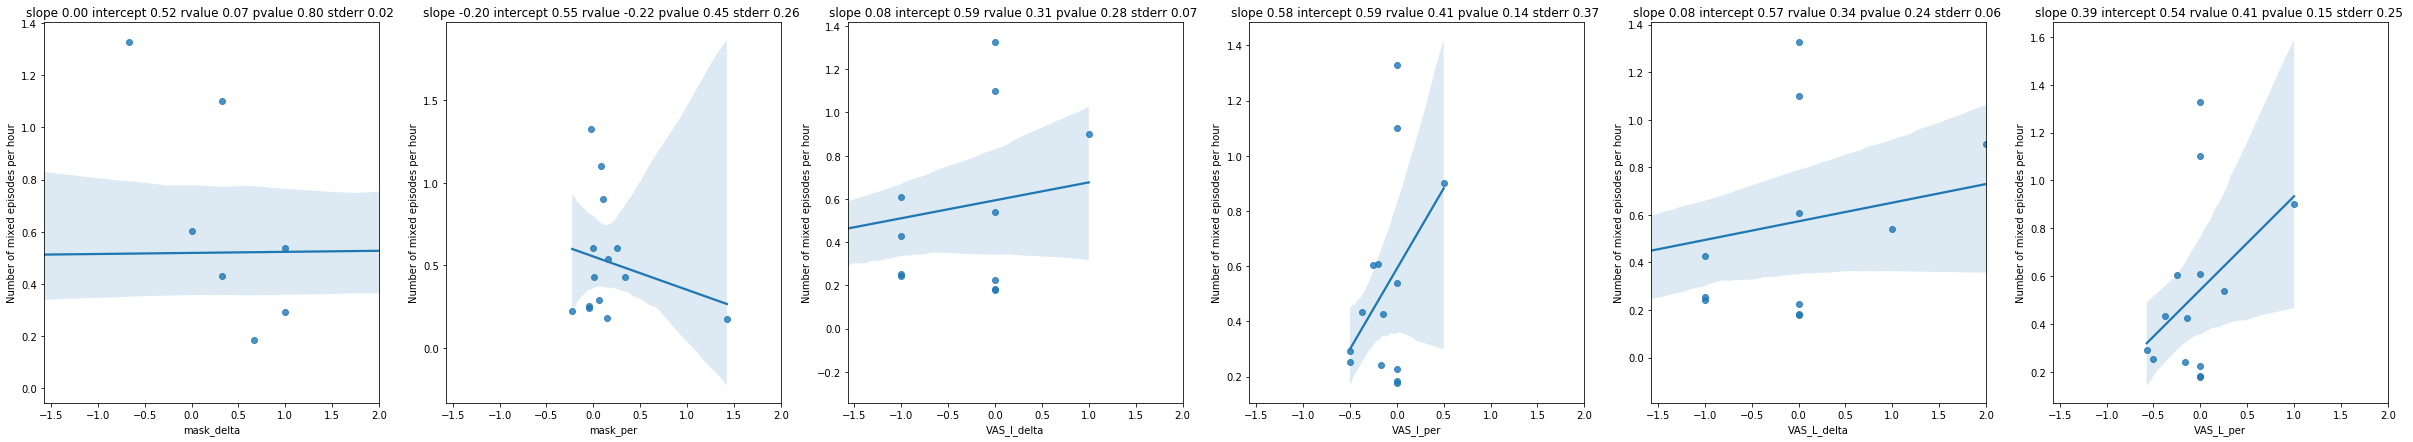

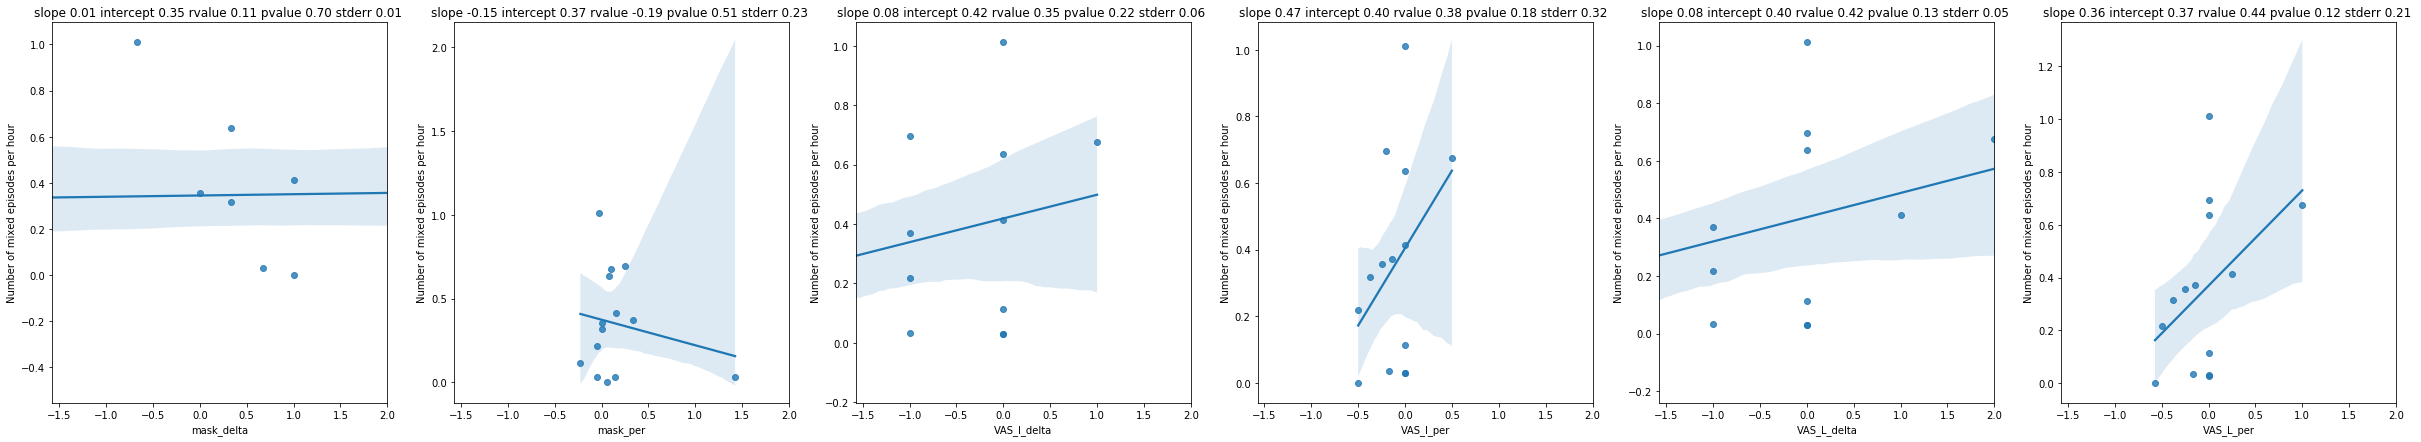

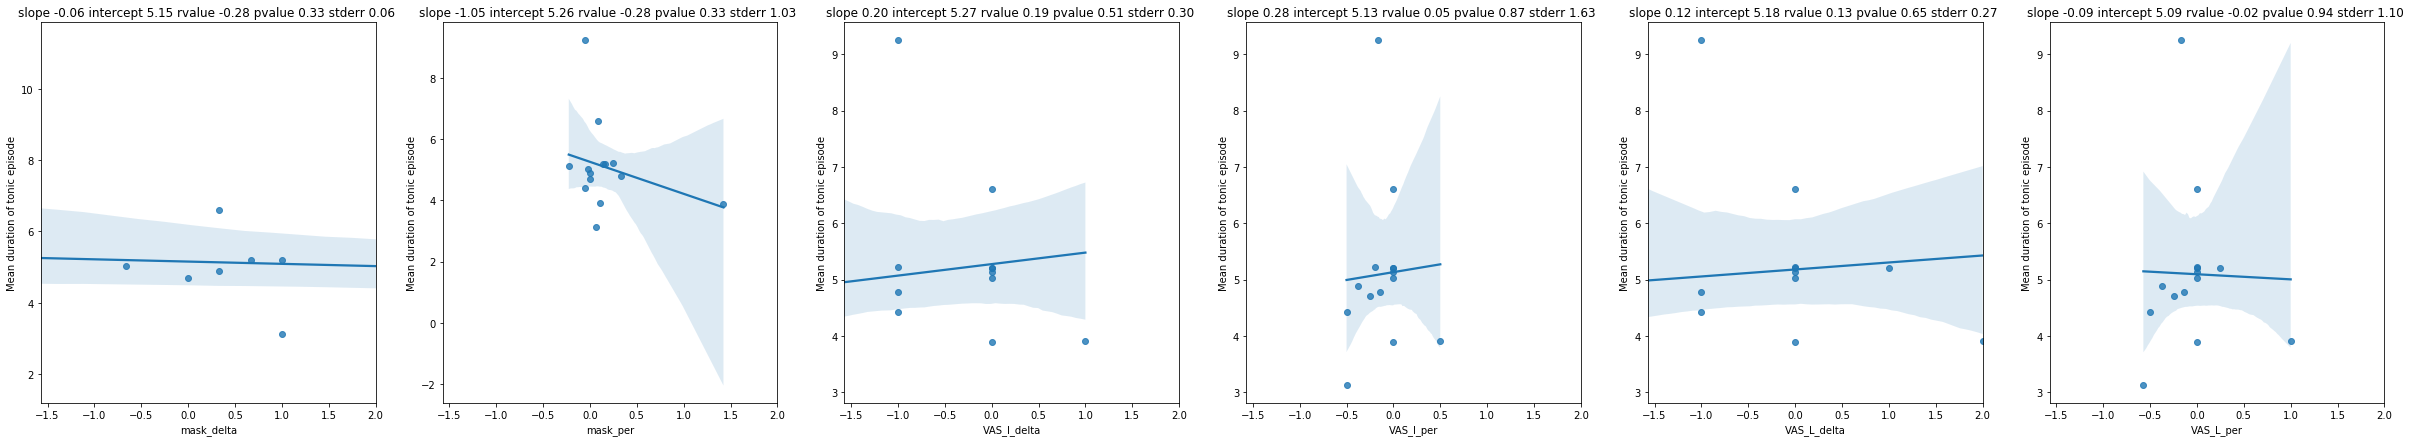

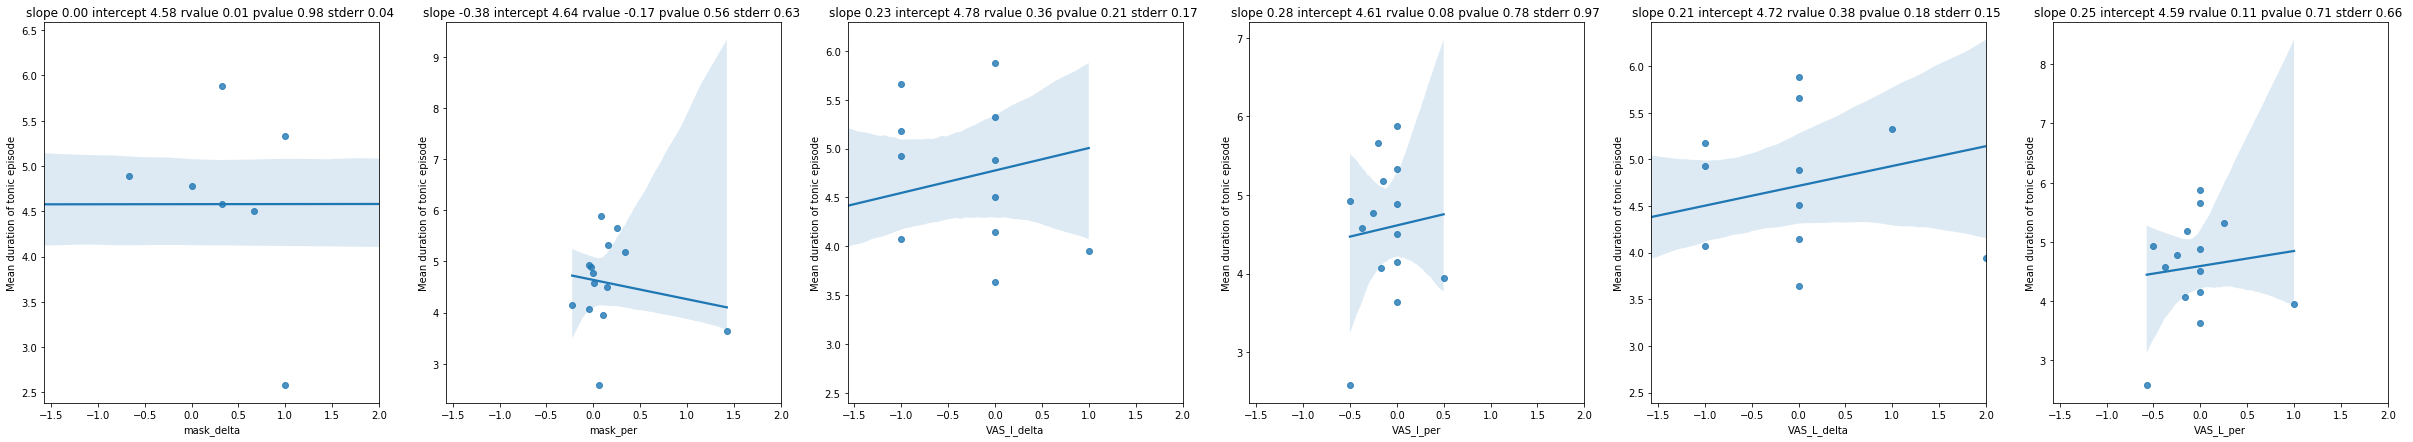

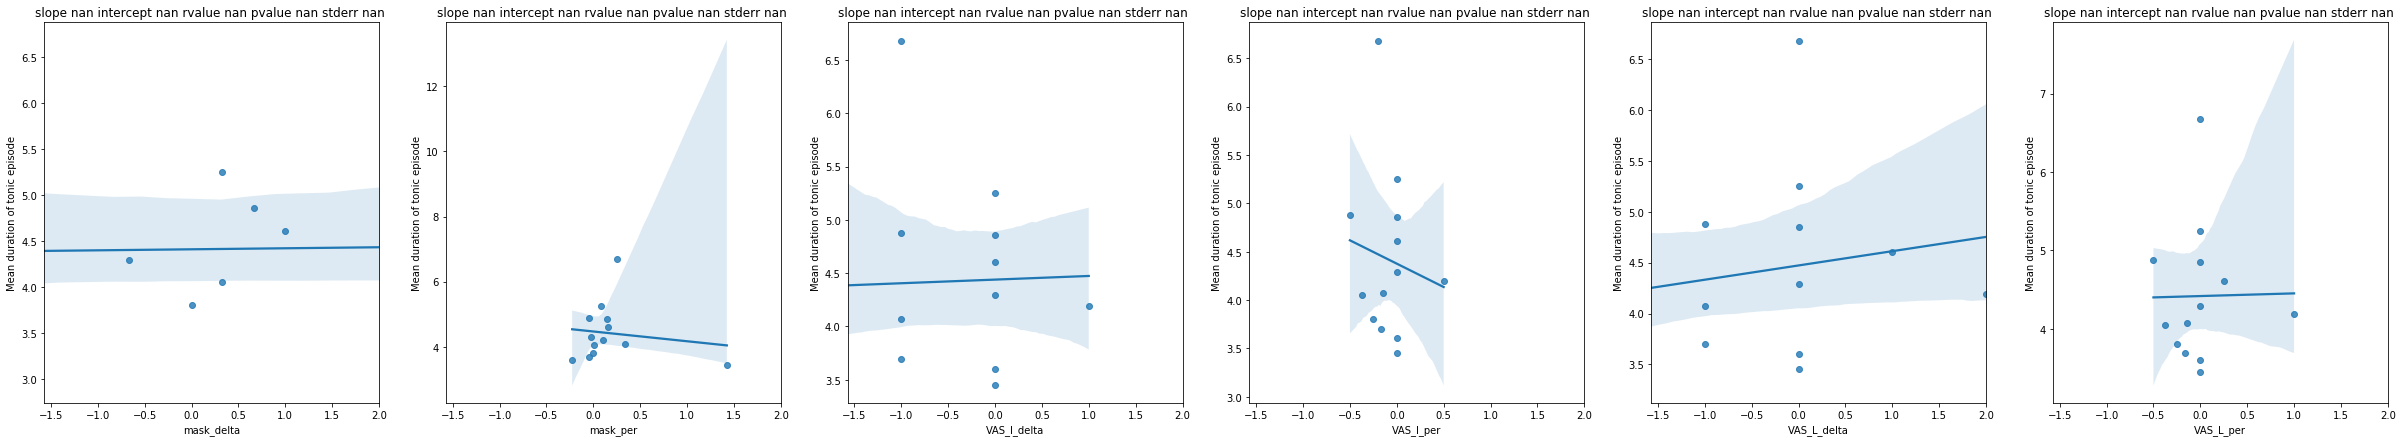

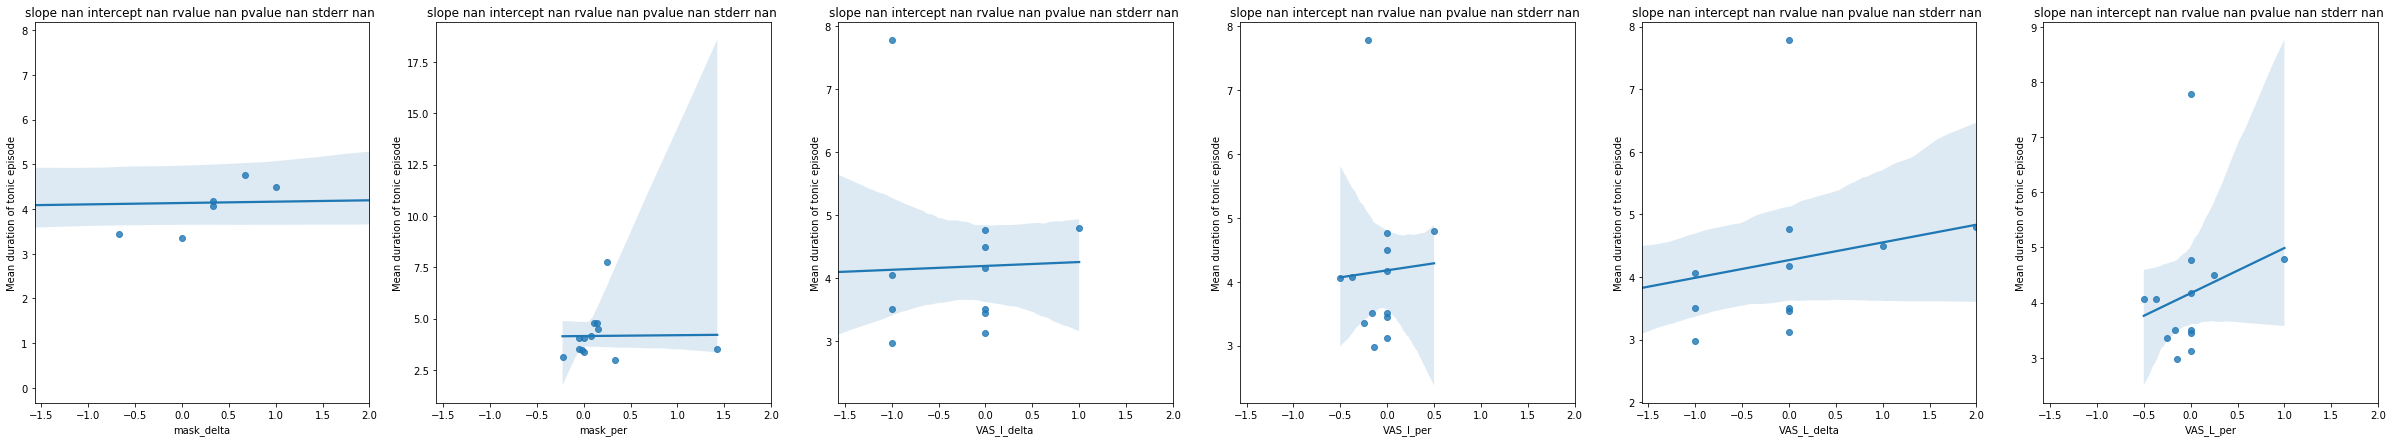

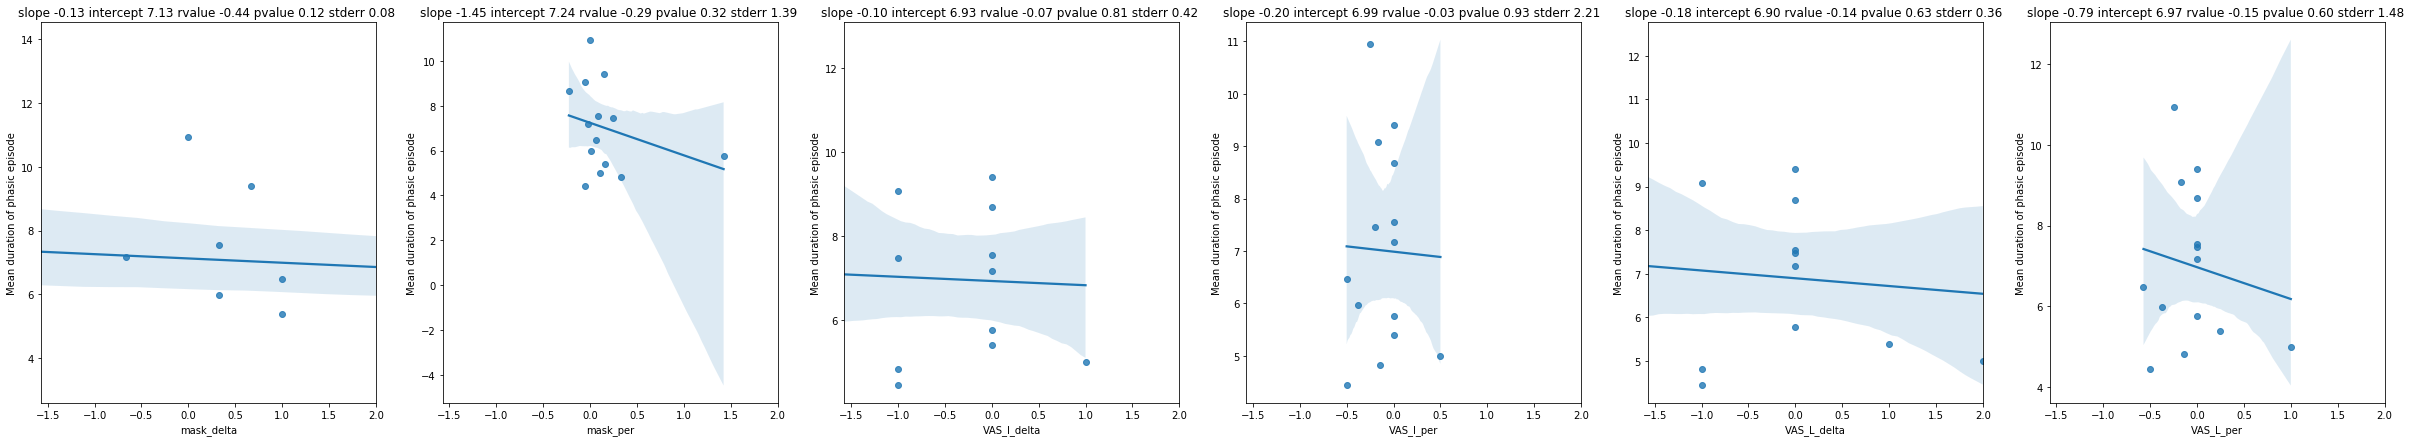

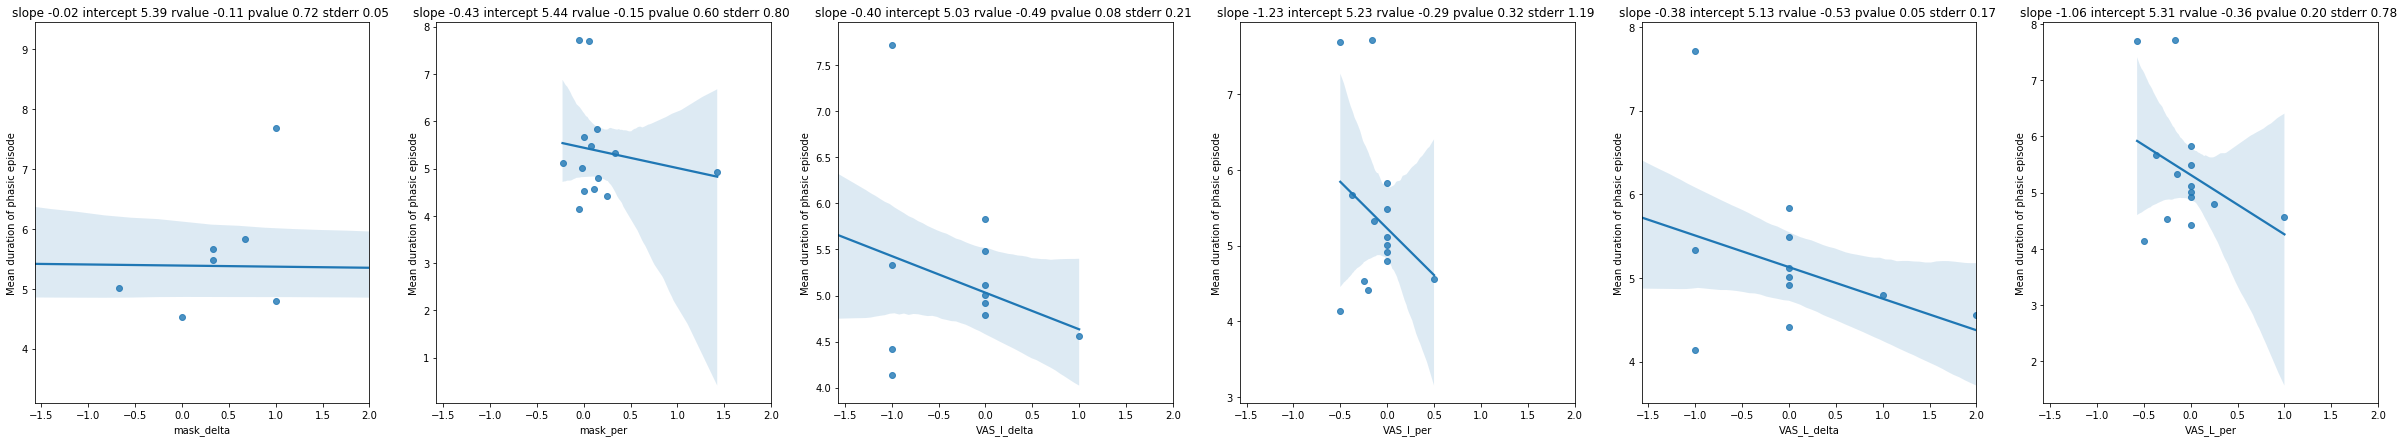

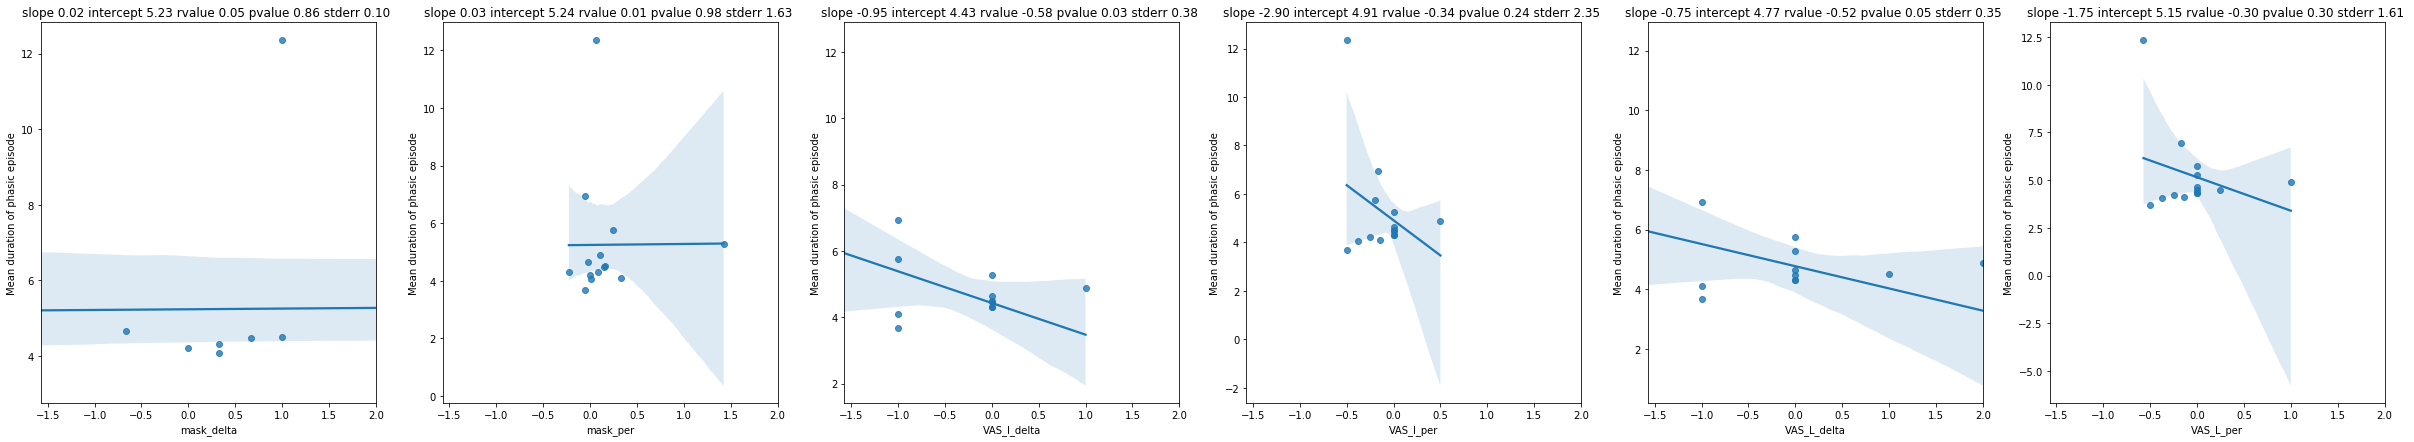

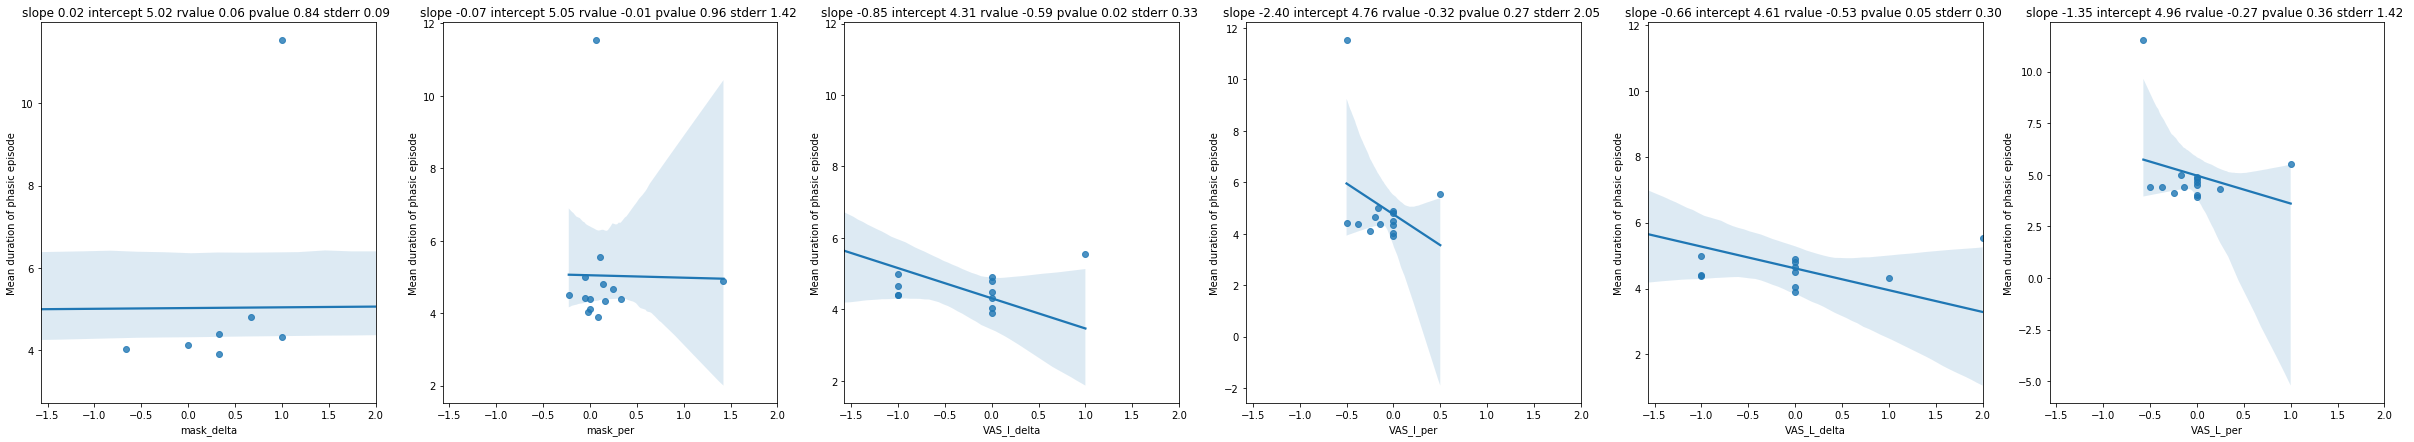

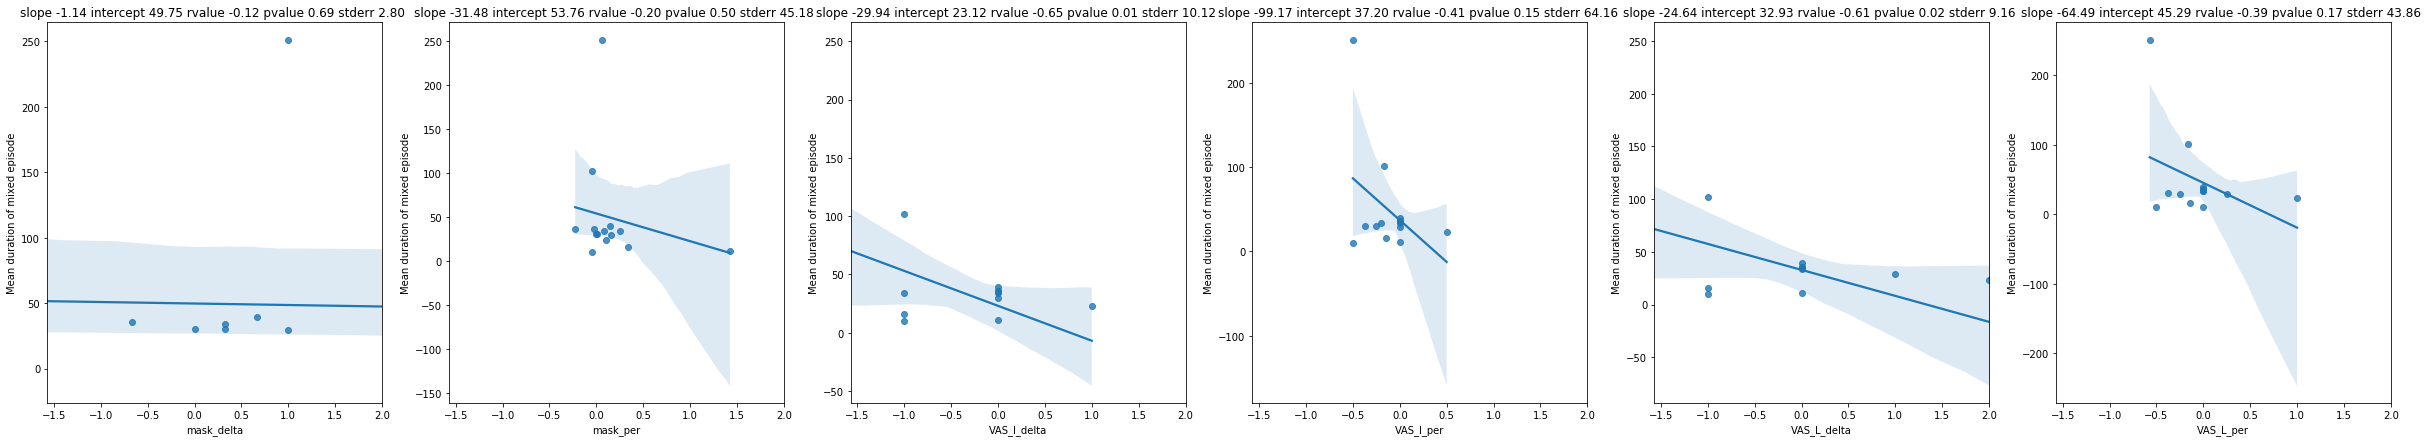

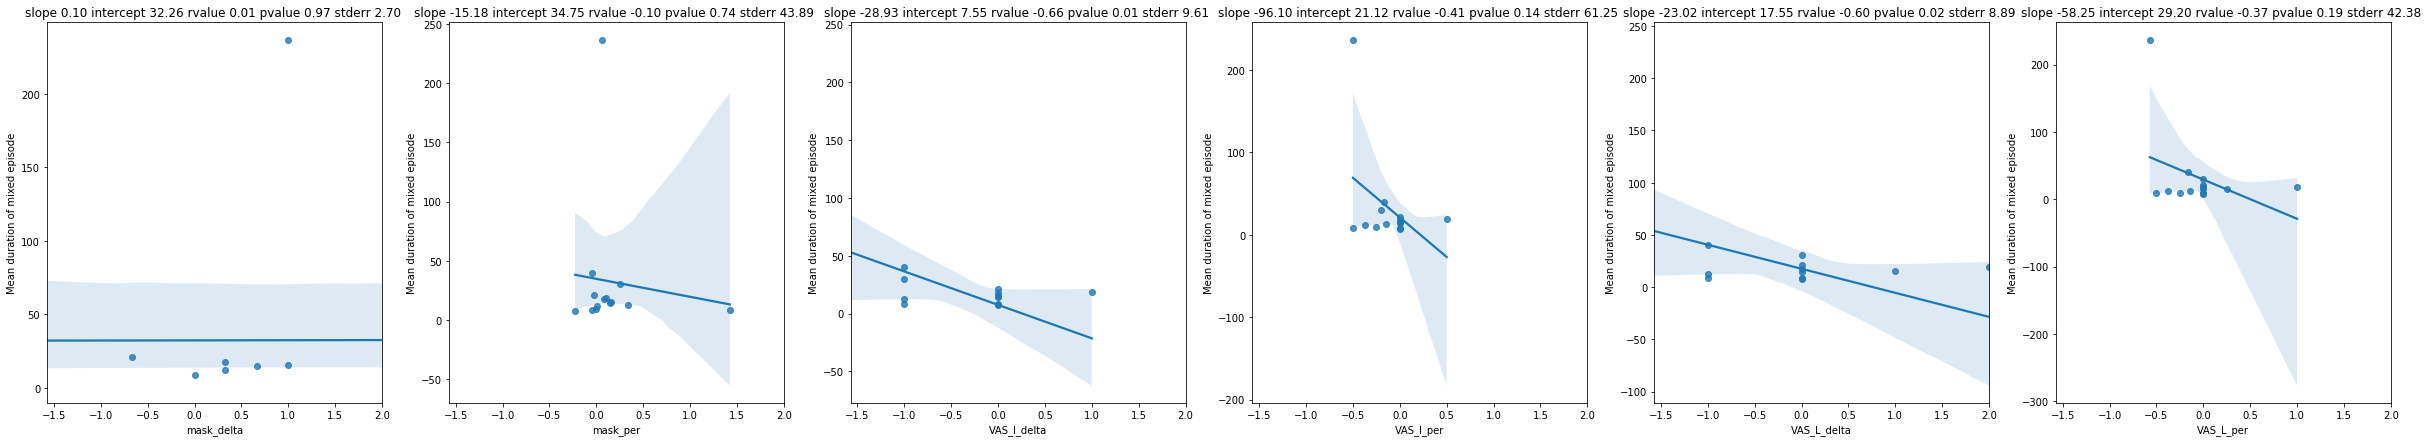

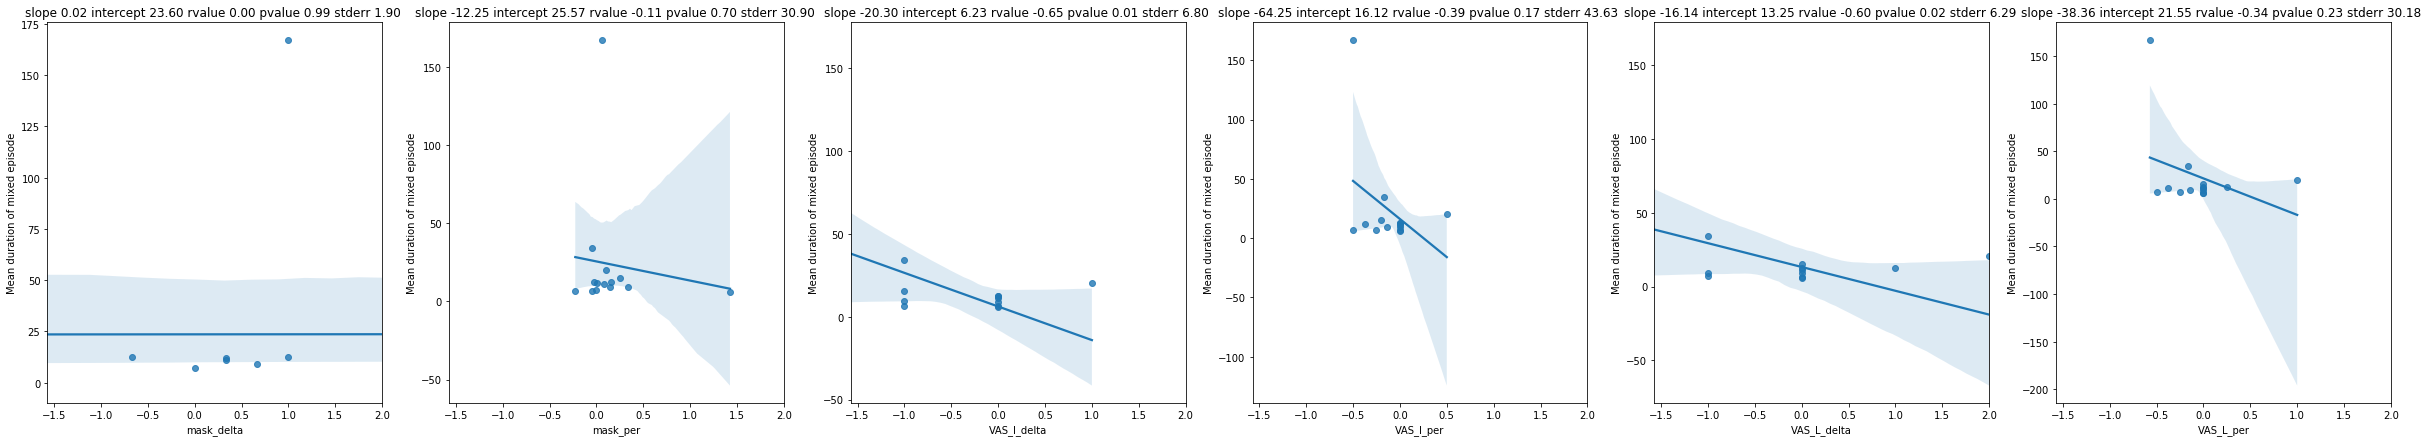

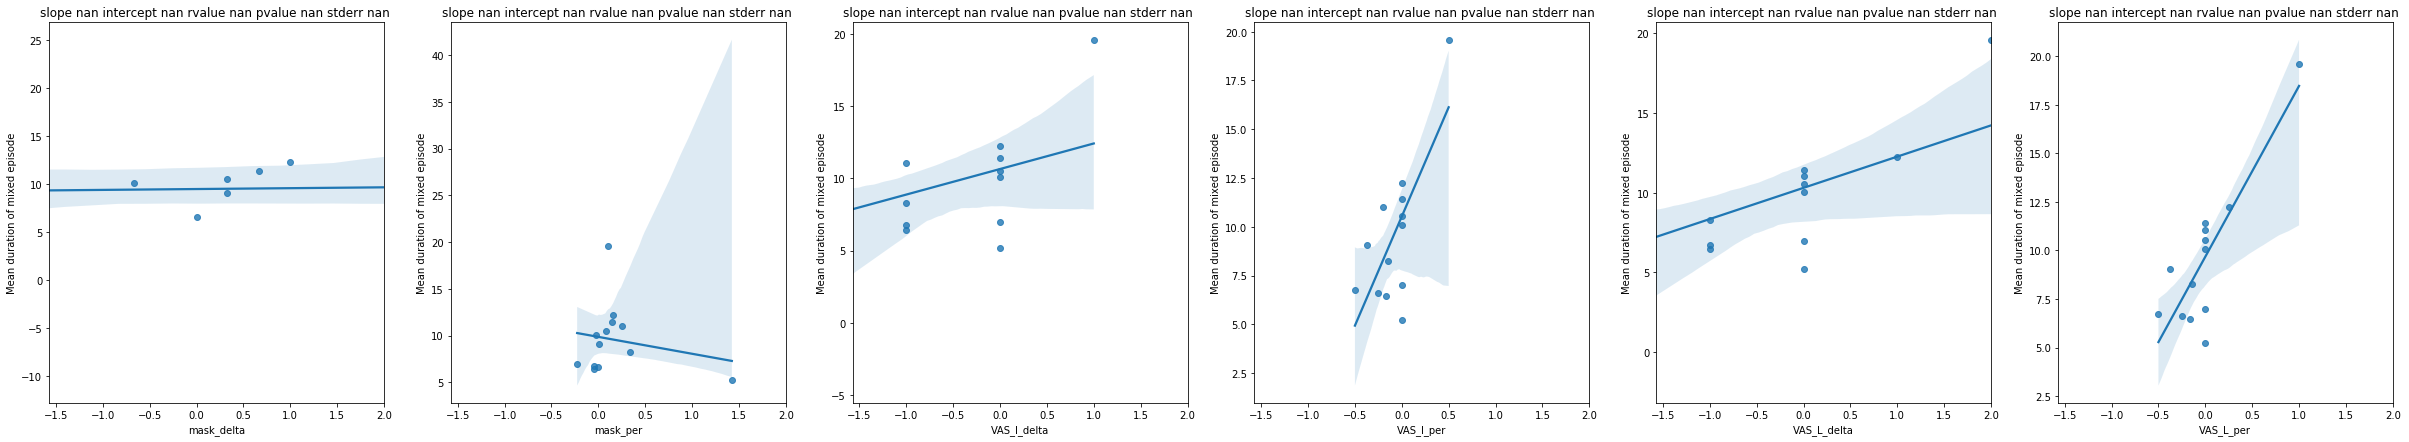

In [13]:
import seaborn as sns
import collections

meta_results = pd.DataFrame()

data = reports.query("category != 'control'")
for y_axis in quantitative_variables:
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            title = ""
            for a, re in zip(regression_result._fields, regression_result):
                title = title + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title(f"{title}")
            ax.set_xlim(min(data_loc[x_axis].values)-1,max(data_loc[x_axis].values)+1)
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])



In [16]:
print(meta_results)

         x_axis                          y_axis  THR_classif        slope  \
0    mask_delta             Clean data duration            2   278.471913   
0      mask_per             Clean data duration            2  1823.735306   
0   VAS_I_delta             Clean data duration            2   277.340120   
0     VAS_I_per             Clean data duration            2  6612.973619   
0   VAS_L_delta             Clean data duration            2   164.453295   
..          ...                             ...          ...          ...   
0      mask_per  Mean duration of mixed episode            5          NaN   
0   VAS_I_delta  Mean duration of mixed episode            5          NaN   
0     VAS_I_per  Mean duration of mixed episode            5          NaN   
0   VAS_L_delta  Mean duration of mixed episode            5          NaN   
0     VAS_L_per  Mean duration of mixed episode            5          NaN   

       intercept    rvalue    pvalue       stderr  
0   28371.523058  0.451

In [17]:
meta_results.query("pvalue < 0.05")

x_axis                             y_axis  THR_classif       slope  \
0    VAS_I_per               Total burst duration            5  451.164454   
0    VAS_L_per               Total burst duration            5  321.570143   
0    VAS_L_per              Total number of burst            5  303.888157   
0    VAS_I_per           Total number of episodes            2  160.956198   
0    VAS_I_per           Total number of episodes            3   86.606409   
0  VAS_I_delta       Number of bursts per episode            2   -2.247009   
0  VAS_L_delta       Number of bursts per episode            2   -1.977595   
0  VAS_I_delta       Number of bursts per episode            3   -2.697363   
0  VAS_L_delta       Number of bursts per episode            3   -2.205552   
0  VAS_I_delta       Number of bursts per episode            4   -3.055722   
0  VAS_L_delta       Number of bursts per episode            4   -2.432200   
0    VAS_I_per        Number of episodes per hour            2   15.793011   
0  VAS_I_delta  Number of tonic episodes per hour            2    0.988428   
0    VAS_I_per  Number of tonic episodes per hour            2    5.356727   
0  VAS_L_delta  Number of tonic episodes per hour            2    0.755939   
0    VAS_L_per  Number of tonic episodes per hour            2    3.022730   
0    VAS_I_per  Number of mixed episodes per hour            3    0.912755   
0  VAS_I_delta    Mean duration of phasic episode            4   -0.954894   
0  VAS_I_delta    Mean duration of phasic episode            5   -0.845467   
0  VAS_L_delta    Mean duration of phasic episode            5   -0.660962   
0  VAS_I_delta     Mean duration of mixed episode            2  -29.935283   
0  VAS_L_delta     Mean duration of mixed episode            2  -24.643595   
0  VAS_I_delta     Mean duration of mixed episode            3  -28.929917   
0  VAS_L_delta     Mean duration of mixed episode            3  -23.018771   
0  VAS_I_delta     Mean duration of mixed episode            4  -20.296845   
0  VAS_L_delta     Mean duration of mixed episode            4  -16.142865   

    intercept    rvalue    pvalue      stderr  
0  338.490932  0.712951  0.004207  128.095902  
0  303.180408  0.749374  0.002033   82.023885  
0  397.480355  0.548609  0.042206  133.692797  
0  182.077624  0.555676  0.039101   69.519309  
0  109.825731  0.541034  0.045732   38.862568  
0    9.270129 -0.553644  0.039976    0.975664  
0    9.924826 -0.559029  0.037687    0.846729  
0    6.659964 -0.628929  0.015976    0.962557  
0    7.554135 -0.589999  0.026354    0.871297  
0    6.121939 -0.624533  0.016959    1.103106  
0    7.177572 -0.570312  0.033208    1.011265  
0   21.801601  0.542835  0.044874    7.053463  
0    5.447027  0.641248  0.013453    0.341438  
0    5.225210  0.658123  0.010506    1.769071  
0    5.085764  0.562652  0.036204    0.320628  
0    4.763020  0.547653  0.042640    1.333141  
0    0.937601  0.542270  0.045142    0.408256  
0    4.430777 -0.584349  0.028201    0.382809  
0    4.310891 -0.594858  0.024839    0.329805  
0    4.610672 -0.533538  0.049427    0.302466  
0   23.117990 -0.649470  0.011947   10.117396  
0   32.934492 -0.613411  0.019649    9.159243  
0    7.547403 -0.655864  0.010868    9.612138  
0   17.546693 -0.598716  0.023684    8.889612  
0    6.227895 -0.652573  0.011414    6.803321  
0   13.247635 -0.595460  0.024656    6.287250